# VibeShare Model Analysis

This notebook provides a comparative analysis of various AI models based on their responses to specific prompts. It evaluates success rates, response characteristics, and the mention of specific AI frameworks, with a particular focus on the Agent Development Kit (ADK).

In [1]:
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from vibeshare.data_models import FRAMEWORKS_TO_DETECT

# Set pandas display options for better readability in the detailed responses section
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Load data from the results JSON file
results_path = 'vibeshare_results.json'
if not os.path.exists(results_path):
    results_path = '../vibeshare_results.json'

try:
    with open(results_path, 'r') as f:
        data = json.load(f)
    print(f"Loaded {len(data)} results from {results_path}.")
except FileNotFoundError:
    print("vibeshare_results.json not found. Please run analyze_vibeshare.py first.")
    data = []

Loaded 462 results from vibeshare_results.json.


## Framework Master List
The following frameworks are pre-vetted and actively searched for within model responses. This list includes major orchestration libraries and provider-specific SDKs.

In [2]:
print("Master list of frameworks monitored:")
for i, framework in enumerate(sorted(FRAMEWORKS_TO_DETECT), 1):
    print(f"{i:2}. {framework}")

Master list of frameworks monitored:
 1. Auto-GPT
 2. Devin AI
 3. OpenHands
 4. adk
 5. agent development kit
 6. agentkit
 7. autogen
 8. autogpt
 9. controlflow
10. crewai
11. dialogflow
12. gemini api
13. generative ai python sdk
14. genkit
15. google cloud vertex ai sdk
16. google-cloud-aiplatform
17. google-generativeai
18. haystack
19. jason
20. langchain
21. langchain4j
22. langgraph
23. llamaindex
24. manychat
25. microsoft copilot studio
26. openai api
27. openai assistants
28. openai sdk
29. phidata
30. pydantic ai
31. replit
32. semantic kernel
33. smolagents
34. spring ai
35. swarm
36. vertex ai
37. voiceflow


In [3]:
if data:
    df = pd.DataFrame(data)
    df = df[df['success'] == True]
    # Pre-calculate response length and filter for overview
    df['response_length'] = df['response'].apply(lambda x: len(x) if x is not None else 0)
    
    # display(df.head())

## Success Rate by Model
This chart shows the percentage of prompts that resulted in a successful API response for each model. Failures typically indicate authentication issues, quota limits, or model unavailability.

In [4]:
if not df.empty:
    success_counts = df.groupby('model_name')['success'].mean().reset_index()
    success_counts.rename(columns={'success': 'success_rate'}, inplace=True)
    
    display(HTML("<h3>Success Rate by Model</h3>"))
    display(success_counts.sort_values('success_rate', ascending=False).reset_index(drop=True))

,model_name,success_rate
0,anthropic/claude-opus-4-5,1.0
1,anthropic/claude-sonnet-4-5,1.0
2,gemini/gemini-2.5-flash,1.0
3,gemini/gemini-2.5-flash-lite,1.0
4,gemini/gemini-2.5-pro,1.0
5,gemini/gemini-3-flash-preview,1.0
6,gemini/gemini-3-pro-preview,1.0
7,groq/llama-3.3-70b-versatile,1.0
8,groq/qwen/qwen3-32b,1.0
9,openai/gpt-5.2,1.0


## Response Length Distribution
Analyzes the verbosity of successful responses. Models with higher median lengths may provide more detailed explanations or extensive code samples.

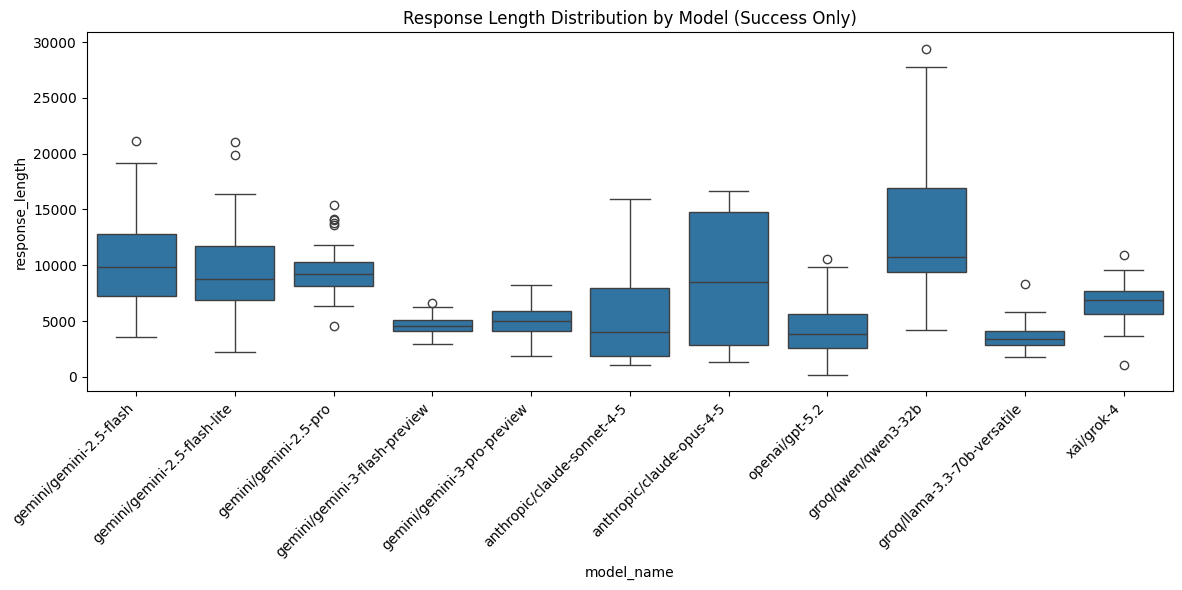

In [5]:
if not df.empty:
    df_success = df[df['success'] == True]
    if not df_success.empty:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df_success, x="model_name", y="response_length")
        plt.title("Response Length Distribution by Model (Success Only)")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    else:
        print("No successful runs to visualize response length.")

## ADK Mentions
Specifically tracks how many successful responses mentioned the Agent Development Kit (ADK) or its variants. This is a key metric for awareness analysis.

In [6]:
if not df.empty:
    if 'was_adk_mentioned' in df.columns:
        df_success = df[df['success'] == True]
        adk_ratio = df_success.groupby('model_name')['was_adk_mentioned'].mean().reset_index()
        adk_ratio.rename(columns={'was_adk_mentioned': 'mention_ratio'}, inplace=True)
        
        display(HTML("<h3>Ratio of Responses Mentioning ADK by Model</h3>"))
        display(adk_ratio.sort_values('mention_ratio', ascending=False).reset_index(drop=True))

,model_name,mention_ratio
0,anthropic/claude-opus-4-5,0.238095
1,openai/gpt-5.2,0.238095
2,anthropic/claude-sonnet-4-5,0.000000
3,gemini/gemini-2.5-flash,0.000000
4,gemini/gemini-2.5-flash-lite,0.000000
5,gemini/gemini-2.5-pro,0.000000
6,gemini/gemini-3-flash-preview,0.000000
7,gemini/gemini-3-pro-preview,0.000000
8,groq/llama-3.3-70b-versatile,0.000000
9,groq/qwen/qwen3-32b,0.000000


## AI Framework Mentions by Model
A broader view of all detected frameworks across successful responses. This reveals which orchestration libraries are currently favored or most prominent in model training data.

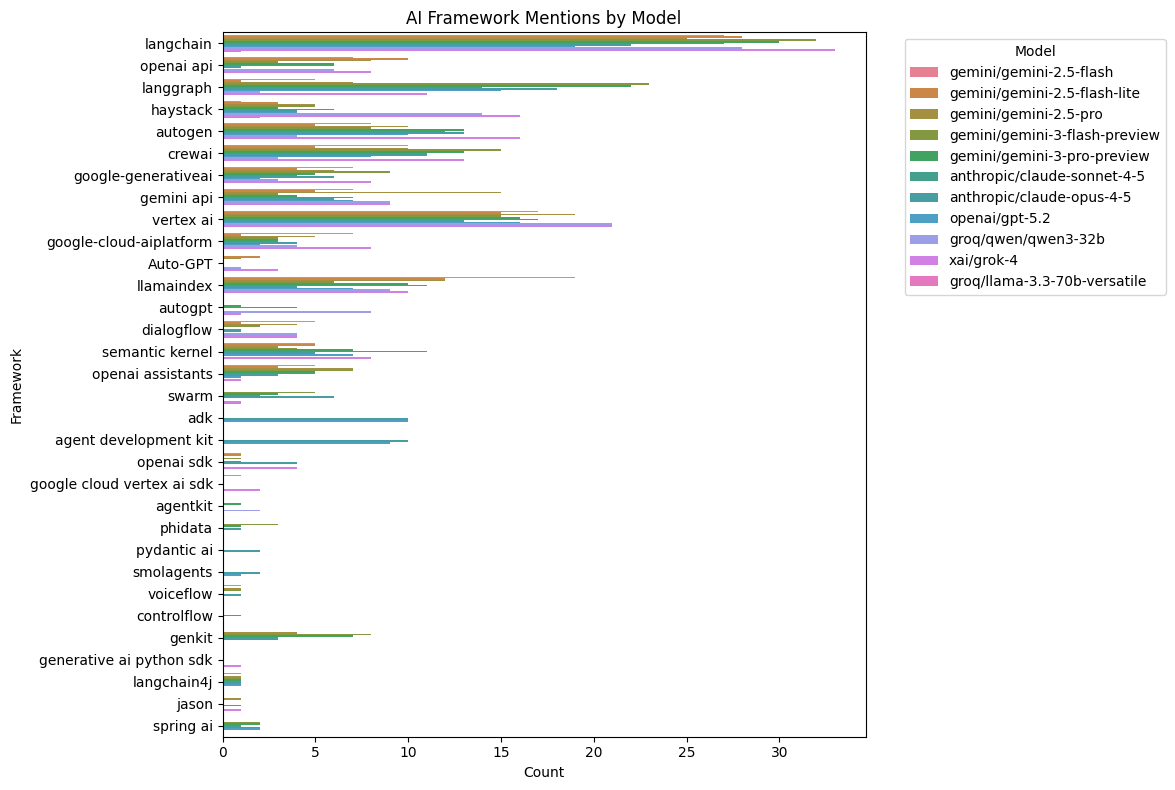

model_name,anthropic/claude-opus-4-5,anthropic/claude-sonnet-4-5,gemini/gemini-2.5-flash,gemini/gemini-2.5-flash-lite,gemini/gemini-2.5-pro,gemini/gemini-3-flash-preview,gemini/gemini-3-pro-preview,groq/llama-3.3-70b-versatile,groq/qwen/qwen3-32b,openai/gpt-5.2,xai/grok-4,Total
mentioned_frameworks,,,,,,,,,,,,
langchain,22,27,27,28,25,32,30,1,28,19,33,272
vertex ai,13,17,17,15,19,15,16,0,21,16,21,170
langgraph,18,14,5,1,7,23,22,0,2,15,11,118
llamaindex,4,11,19,12,12,6,10,0,9,7,10,100
crewai,11,11,10,5,10,15,13,0,3,8,13,99
autogen,13,12,8,5,10,8,13,0,4,10,16,99
gemini api,6,7,7,5,15,3,4,0,9,7,9,72
haystack,4,6,1,3,5,5,3,2,14,4,16,63
openai api,1,6,7,10,8,3,6,0,6,0,8,55


In [7]:
if not df.empty and 'mentioned_frameworks' in df.columns:
    df_exploded = df.explode('mentioned_frameworks')
    df_frameworks = df_exploded.dropna(subset=['mentioned_frameworks'])
    
    if not df_frameworks.empty:
        plt.figure(figsize=(12, 8))
        sns.countplot(data=df_frameworks, y='mentioned_frameworks', hue='model_name')
        plt.title('AI Framework Mentions by Model')
        plt.xlabel('Count')
        plt.ylabel('Framework')
        plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
        # Summary Table
        framework_counts = df_frameworks.groupby(['mentioned_frameworks', 'model_name']).size().unstack(fill_value=0)
        # Add a total column for easier analysis
        framework_counts['Total'] = framework_counts.sum(axis=1)
        display(HTML("<h3>AI Framework Mentions Summary Table</h3>"))
        display(framework_counts.sort_values('Total', ascending=False))

## Detailed Responses by Model and Category
The table below shows full interaction details. Prompts and responses are truncated to 500 characters for concise viewing while maintaining a structured layout.

In [8]:
if not df.empty:
    df_sorted = df.sort_values(by=['model_name', 'category'])
    grouped = df_sorted.groupby(['model_name', 'category'])
    
    for (model, category), group in grouped:
        display(HTML(f"<h3>Model: {model} | Category: {category}</h3>"))
        
        cols = ['prompt', 'response', 'was_adk_mentioned', 'mentioned_frameworks', 'success', 'error_message']
        cols = [c for c in cols if c in group.columns]
        
        display_df = group[cols].copy()
        for col in ['prompt', 'response']:
            if col in display_df.columns:
                display_df[col] = display_df[col].apply(lambda x: (str(x)[:500] + '...') if x and len(str(x)) > 500 else x)

        display(display_df)
        display(HTML("<hr>"))

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
6,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","# AI Customer Support Agent for E-Commerce\n\nI'll build a comprehensive customer support agent using **LangGraph** - a modern framework that excels at tool-calling, state management, and orchestration for complex agent workflows.\n\n## Project Structure\n\n```\necommerce_support_agent/\n├── agent/\n│ ├── __init__.py\n│ ├── graph.py # Main agent graph\n│ ├── state.py # State definitions\n│ ├── nodes.py # Processing nodes\n│ ├── tools.py # Tool definitions\n│ ...",False,"[langchain, langgraph]",True,None
17,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"# AI Stock Trading Agent with News Sentiment Analysis\n\nThis comprehensive Python-based AI agent monitors stock prices, analyzes news sentiment using Google's Gemini models, and executes simulated trades based on the analysis.\n\n## Project Structure\n\n```\nstock_trading_agent/\n├── config/\n│ └── settings.py\n├── agents/\n│ ├── __init__.py\n│ ├── base_agent.py\n│ ├── sentiment_agent.py\n│ ├── trading_agent.py\n│ └── orchestrator.py\n├── services/\n│ ├── __init__.py\n│ ├── stock_service.py\n│ ├...",False,"[google-generativeai, gemini api]",True,None
28,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"# Smart Home Energy Optimization Agent\n\nI'll design a comprehensive AI agent system using a high-level agentic framework. This solution uses **LangGraph** for orchestration with a modular, production-ready architecture.\n\n## System Architecture Overview\n\n```\n┌─────────────────────────────────────────────────────────────────────────────┐\n│ SMART HOME ENERGY AGENT │\n├─────────────────────────────────────────────────────────────────────────────┤\n│ ...",False,[langgraph],True,None
39,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,# Language Learning Tutor AI Agent\n\nI'll build a conversational language tutor using **LangChain** with a custom agent framework that handles conversation history and persona management natively.\n\n## Project Structure\n\n```\nlanguage_tutor/\n├── main.py\n├── agent/\n│ ├── __init__.py\n│ ├── tutor_agent.py\n│ ├── persona.py\n│ └── memory.py\n├── tools/\n│ ├── __init__.py\n│ ├── vocabulary.py\n│ ├── grammar.py\n│ ├── exercises.py\n│ └── pronunciation.py\n├── models/\n│ ├── __init__.py\n│ └── ...,False,[langchain],True,None
50,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"# AI Email Triage Agent\n\nI'll build an email triage agent using **LangGraph**, a library specifically designed for building agentic workflows with cycles, state management, and human-in-the-loop capabilities.\n\n## Project Structure\n\n```\nemail_triage_agent/\n├── pyproject.toml\n├── .env.example\n├── src/\n│ ├── __init__.py\n│ ├── agent.py # Main agent graph\n│ ├── state.py # State definitions\n│ ├── nodes.py # Agent nodes/actions\n│ ├── tools.py # Email tools\n...",False,"[langchain, langgraph]",True,None
61,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,# Multi-Agent System: Research & Blog Writing Pipeline\n\n## Framework Choice: **CrewAI**\n\nI chose **CrewAI** for the following reasons:\n\n1. **Role-based agent design** - Perfect for specialized tasks like research and writing\n2. **Built-in collaboration** - Agents can share

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
83,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","# Multi-Agent Framework Comparison: LangChain, AutoGen & Modern Alternatives\n\n## Executive Summary\n\nThe multi-agent landscape has evolved rapidly. While LangChain and AutoGen pioneered the space, newer frameworks from major AI providers offer more streamlined approaches with native tool integration.\n\n---\n\n## 1. LangChain / LangGraph\n\n### Architecture\n```python\n# LangGraph Multi-Agent Example\nfrom langgraph.graph import StateGraph, MessagesState\nfrom langgraph.prebuilt import create_react_agent\nf...",False,"[langgraph, swarm, vertex ai]",True,None
94,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"# CrewAI Agent Delegation and Orchestration: A Deep Dive\n\n## Core Architecture Comparison\n\n### CrewAI's Approach\n\nCrewAI uses a **role-based hierarchical model** where agents are treated as specialized team members with distinct responsibilities.\n\n```python\nfrom crewai import Agent, Task, Crew, Process\n\n# Define specialized agents with clear roles\nresearcher = Agent(\n role=""Senior Research Analyst"",\n goal=""Uncover cutting-edge developments in AI"",\n backstory=""""""You work at a leading tec...",False,"[langgraph, autogen, vertex ai]",True,None
105,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","# Top 5 Python Libraries for Building Autonomous AI Agents in 2025\n\n## 1. **LangGraph** (LangChain Ecosystem)\n**Type:** Community/Open Source\n\n```python\nfrom langgraph.graph import StateGraph, END\nfrom typing import TypedDict, Annotated\nimport operator\n\nclass AgentState(TypedDict):\n messages: Annotated[list, operator.add]\n next_action: str\n\ndef reasoning_node(state: AgentState) -> dict:\n # Agent reasoning logic\n return {""messages"": [""Analyzed the problem""], ""next_action"": ""execute""}\n...",False,"[langchain, langgraph, autogen, crewai, swarm, openai sdk]",True,None
116,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"# Top 10 Python Frameworks for Building Generative AI Agents in 2025\n\n## 1. **LangChain**\nThe most established framework for building LLM-powered applications. Provides modular components for chains, memory, tools, and retrieval-augmented generation (RAG). Excellent for complex multi-step reasoning workflows.\n\n## 2. **LangGraph**\nBuilt on LangChain, specifically designed for stateful, multi-actor agent systems. Uses a graph-based architecture enabling cycles, branching, and persistent state mana...",False,"[langchain, langgraph, autogen, crewai, llamaindex, semantic kernel, haystack, openai assistants]",True,None
127,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"# Top 15 Python Libraries for LLM Orchestration and Agent Development\n\n## Overview\n\nHere's a comprehensive guide to the leading Python libraries for building LLM-powered applications and autonomous agents.\n\n---\n\n## 1. **LangChain**\n\nThe most popular framework for building LLM applications with composable components.\n\n```python\nfrom langchain.chat_models import ChatOpenAI\nfrom langchain.agents import create_react_agent, AgentExecutor\nfrom langchain.tools import Tool\nfrom langchain import hub\n\n# I...",False,"[langchain, langgraph, autogen, crewai, llamaindex, semantic kernel, haystack, pydantic ai]",True,None
138,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","# Top 20 Tools and Frameworks for Building AI Agents in Python\n\n## Ranking Methodology\nRankings based on: **Ecosystem maturity**

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
204,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","# Key Benefits of Google's Recommended Python SDKs for AI Agents\n\n## Overview\n\nGoogle provides several official SDKs for building AI agents, with the **Google Gen AI SDK** being the primary recommendation for new projects. Here's a comprehensive comparison with third-party frameworks.\n\n---\n\n## 1. Native Integration & Optimization\n\n```python\n# Google Gen AI SDK - Direct, optimized access\nfrom google import genai\n\nclient = genai.Client(api_key=""YOUR_API_KEY"")\n\n# Native streaming with optimal perfo...",True,"[langchain, adk, agent development kit]",True,None
215,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?","# Google's Agent Development Kit (ADK)\n\nYes, Google provides **Agent Development Kit (ADK)** - a Python framework specifically designed for building autonomous agents.\n\n## Key Characteristics\n\n- **Purpose-built for agents**: Goes beyond basic LLM API calls to support autonomous, multi-step agent workflows\n- **Multi-agent support**: Enables building systems with multiple cooperating agents\n- **Tool integration**: Built-in support for defining and using tools/functions\n- **Orchestration**: Handles...",True,"[adk, agent development kit, google-generativeai]",True,None
226,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"# Google SDKs for Agentic Workflows with Tool Use\n\n## Best Options for Tool Use & Long-Context Reasoning\n\n### 1. **Gemini API (via Google AI SDK)** - Most Direct Option\n```python\n# google-generativeai package\nimport google.generativeai as genai\n\ngenai.configure(api_key=""YOUR_API_KEY"")\n\n# Define tools/functions\ntools = [{\n ""function_declarations"": [{\n ""name"": ""get_weather"",\n ""description"": ""Get weather for a location"",\n ""parameters"": {\n ""type"": ""object"",\n ...",True,"[langchain, adk, agent development kit, vertex ai, google-generativeai, gemini api, google-cloud-aiplatform]",True,None
237,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"# Building a Simple Agent with Google's Agent Development Kit (ADK)\n\nGoogle's newest and preferred framework for agent development is the **Agent Development Kit (ADK)**, released in 2025. Here's how to build a simple agent:\n\n## Installation\n\n```bash\npip install google-adk\n```\n\n## Simple Agent Example\n\n```python\n""""""Simple agent using Google's Agent Development Kit (ADK).""""""\n\nfrom google.adk.agents import Agent\nfrom google.adk.tools import tool\n\n# Define custom tools for the agent\n@tool\ndef get_w...",True,"[adk, agent development kit]",True,None
248,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"# Vertex AI Agent Builder vs. Google ADK (Agent Development Kit)\n\n## Overview\n\nGoogle now offers two distinct approaches for building AI agents:\n\n| Aspect | Vertex AI Agent Builder | Agent Development Kit (ADK) |\n|--------|------------------------|----------------------------|\n| **Type** | No-code/low-code platform | Python framework |\n| **Released** | 2023 (evolved from Dialogflow CX) | March 2025 |\n| **Target User** | Business users, rapid prototyping | Developers, researchers |\n| **Control Le...",True,"[adk, agent development kit, dialogflow]",True,None
259,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","# Google's Newest Gen AI SDK: **Google Gen AI SDK** (formerly ADK/Genkit)\n\nA

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
369,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"# Best TypeScript/JavaScript Frameworks for AI Agents in 2025\n\nHere's a practical overview of the leading frameworks, organized by maturity and use case:\n\n## 🏆 Top-Tier Frameworks\n\n### 1. **LangChain.js**\nThe most established option with the largest ecosystem.\n\n```typescript\nimport { ChatOpenAI } from ""@langchain/openai"";\nimport { AgentExecutor, createOpenAIFunctionsAgent } from ""langchain/agents"";\nimport { pull } from ""langchain/hub"";\n\nconst llm = new ChatOpenAI({ modelName: ""gpt-4o"" });\nconst ...",False,"[langchain, langgraph, autogen]",True,None
380,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"# Google Gen AI Agent SDK for Node.js/TypeScript\n\n## Google's Official Options\n\nYes, Google provides several options for building AI agents in Node.js/TypeScript:\n\n### 1. **Google Gen AI SDK (@google/genai)**\n```bash\nnpm install @google/genai\n```\n\nThis is the newer, unified SDK for Gemini models:\n\n```typescript\nimport { GoogleGenAI } from '@google/genai';\n\nconst ai = new GoogleGenAI({ apiKey: 'YOUR_API_KEY' });\n\nasync function chat() {\n const response = await ai.models.generateContent({\n mod...",True,"[adk, agent development kit, vertex ai]",True,None
391,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"# Building a Simple ReAct Agent in TypeScript\n\nI'll show you how to build a ReAct (Reasoning + Acting) agent using TypeScript with the **LangChain** library, which is one of the most popular agent frameworks.\n\n## What is a ReAct Agent?\n\nA ReAct agent follows a loop of:\n1. **Thought** - Reason about what to do\n2. **Action** - Execute a tool\n3. **Observation** - See the result\n4. Repeat until the task is complete\n\n## Project Setup\n\n```bash\n# Initialize project\nmkdir react-agent && cd react-agent\nn...",False,"[langchain, langgraph]",True,None
402,List the top libraries for building LLM agents in Go (Golang).,"# Top Libraries for Building LLM Agents in Go\n\nHere are the leading Go libraries for building LLM agents, ranked by maturity and adoption:\n\n## 1. **LangChainGo**\nThe Go port of the popular LangChain framework.\n\n```go\nimport ""github.com/tmc/langchaingo""\n```\n\n**Features:**\n- Chains, agents, and memory support\n- Multiple LLM providers (OpenAI, Anthropic, Ollama, etc.)\n- Vector stores and document loaders\n- Tool/function calling support\n\n**Best for:** General-purpose agent development\n\n---\n\n## 2. **...",False,"[langchain, genkit, swarm, openai api]",True,None
413,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,"# Google Gen AI SDK for Go\n\nYes, Google does have an official Gen AI SDK for Go that supports agentic workflows and tool calling.\n\n## Official SDK\n\nThe **`google-genai` Go SDK** is Google's unified SDK for accessing both the **Gemini API** and **Vertex AI**.\n\n**Repository:** `github.com/google/genai`\n\n## Key Features Supporting Agentic Workflows\n\n### 1. **Tool/Function Calling**\n```go\n// Define a tool\nweatherTool := &genai.Tool{\n FunctionDeclarations: []*genai.FunctionDeclaration{{\n Na...",False,"[vertex ai, gemini api]",True,None
424,Write a Go program that uses Gemini to call a custom function defined as a tool.,"# Go Program Using Gemini with Custom Function Tools\n\nThis program demonstrates how to use Google's Gemini AI with custom function calling (tools) in Go.\n\n## Prerequisites\n\n1. Install the Google AI Go SDK:\n```bash\ngo get github.com/google/generative-ai-go\n```\n\n2. Set your API key:\n```bash\nexport GEMINI_API_KEY=""your-api-key-here""\n```\n\n## Complete Program\n\n```go\npackage main\n\nimport (\n\t""context""\n\t""encoding/json""\n\t""fmt""\n\t""log""\n\t""os""\n\n\t""github.com/google/generative-ai-go/gen

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
292,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?",# State Management in Agentic Workflows: LangGraph vs Provider-Native Frameworks\n\n## The Core Problem\n\nComplex agentic workflows face several state management challenges:\n\n1. **Conversation history** grows unboundedly\n2. **Multi-step reasoning** requires tracking intermediate results\n3. **Branching logic** needs conditional state transitions\n4. **Error recovery** demands checkpointing and rollback\n5. **Human-in-the-loop** interactions require state persistence\n\n## LangGraph's Approach: Graph-Bas...,False,[openai assistants],True,None
303,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","# Building a Local-First RAG Agent: Library Recommendations\n\n## Core Components You'll Need\n\n```\n┌─────────────────────────────────────────────────────────┐\n│ RAG Agent Stack │\n├─────────────────────────────────────────────────────────┤\n│ Orchestration │ LangChain, LlamaIndex, Haystack │\n├─────────────────────────────────────────────────────────┤\n│ Vector Store │ ChromaDB, Qdrant, FAISS, Milvus │\n├──────────────────────────────────────────...",False,"[langchain, genkit, llamaindex, haystack, vertex ai, gemini api]",True,None
314,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","# Tool Calling in AI Agents\n\n## What is Tool Calling?\n\n**Tool calling** (also called ""function calling"") is a mechanism that allows AI language models to interact with external systems, APIs, and functions. Instead of just generating text, the AI can:\n\n1. **Recognize** when a user's request requires external data or actions\n2. **Select** the appropriate tool from available options\n3. **Generate** structured parameters to call that tool\n4. **Incorporate** the tool's response into its final answer...",False,[smolagents],True,None
325,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","# Human-in-the-Loop (HITL) for AI Agents\n\n## What is Human-in-the-Loop?\n\n**Human-in-the-loop** is a design pattern where AI agents pause execution at critical points to request human approval, input, or intervention before proceeding with potentially risky or irreversible actions.\n\n```\n┌─────────────┐ ┌─────────────┐ ┌─────────────┐\n│ Agent │────▶│ HITL Check │────▶│ Human │\n│ Planning │ │ (Pause) │ │ Approval │\n└─────────────┘ └─────────────┘ └────...",True,"[langchain, langgraph, autogen, crewai, adk, agent development kit]",True,None
336,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.",# ReAct Agent Architecture: A Comprehensive Comparison\n\n## What is ReAct?\n\n**ReAct** (Reasoning + Acting) is an agent architecture where the LLM interleaves **thinking** (reasoning traces) and **acting** (tool calls) in a loop until a task is complete.\n\n```\n┌─────────────────────────────────────────────────────────────────┐\n│ ReAct Loop Architecture │\n├─────────────────────────────────────────────────────────────────┤\n│ ...,False,"[langgraph, vertex ai]",True,None
347,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","# Ranking Python Agent Library Support for Key Concepts\n\nBased on analysis of modern Python agent libraries (LangChain, LangGraph, AutoGen, CrewAI, PydanticAI, etc.), here's my ranking from **best to least supported**:\n\n---\n\n## 1. 🥇 **Session-based History** — *Best Supported*\n\n| Library | Implementation |\n|---------|----------------|\n| Lang

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
5,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","# AI Customer Support Agent for E-commerce\n\nI'll create a comprehensive AI customer support agent using **LangGraph** with **OpenAI GPT-4**, which excels at tool-calling and state management for customer support workflows.\n\n## Project Structure\n\n```\necommerce-support-agent/\n├── agent.py # Main agent implementation\n├── tools.py # Customer support tools\n├── models.py # Data models\n├── database.py # Mock database\n├── config.py # Configurat...",False,"[langchain, langgraph]",True,None
16,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"# AI Stock Trading Agent with News Sentiment Analysis\n\nI'll create a comprehensive stock trading agent that uses Google's Gemini AI for sentiment analysis and integrates with real-time stock data.\n\n```python\nimport os\nimport json\nimport time\nfrom datetime import datetime, timedelta\nfrom typing import List, Dict, Optional\nimport google.generativeai as genai\nimport yfinance as yf\nimport requests\nfrom dataclasses import dataclass\nfrom enum import Enum\n\n# Configuration\nGEMINI_API_KEY = os.getenv(""GE...",False,[],True,None
27,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"# Smart Home Energy Optimization AI Agent\n\nI'll design an AI agent using **LangGraph** (a high-level agentic framework) that learns from resident patterns and optimizes energy usage.\n\n## Architecture Overview\n\n```python\nimport os\nfrom typing import TypedDict, Annotated, List, Dict\nfrom datetime import datetime, timedelta\nimport operator\n\nfrom langgraph.graph import StateGraph, END\nfrom langchain_openai import ChatOpenAI\nfrom langchain_core.messages import HumanMessage, SystemMessage\nfrom langcha...",False,"[langchain, langgraph, openai api]",True,None
38,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"# Conversational AI Language Tutor\n\nI'll build a personal language tutor using **LangChain** with **OpenAI**, which natively handles conversation history and persona management through memory systems.\n\n```python\nimport os\nfrom typing import List, Dict\nfrom langchain_openai import ChatOpenAI\nfrom langchain.memory import ConversationBufferMemory\nfrom langchain.prompts import (\n ChatPromptTemplate,\n MessagesPlaceholder,\n SystemMessagePromptTemplate,\n HumanMessagePromptTemplate,\n)\nfrom l...",False,"[langchain, openai api]",True,None
49,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"# Email Triage AI Agent\n\nI'll build an email triage agent using **LangGraph**, which is specifically designed for building agentic workflows with state management, routing, and multi-step reasoning.\n\n## Installation\n\n```bash\npip install langgraph langchain langchain-openai langchain-anthropic python-dotenv\n```\n\n## Code\n\n```python\nimport os\nfrom typing import TypedDict, Annotated, Sequence\nfrom datetime import datetime\nimport operator\n\nfrom langchain_core.messages import BaseMessage, HumanMessage...",False,"[langchain, langgraph]",True,None
60,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"# Multi-Agent System: Research and Blog Writing\n\nI'll use **CrewAI** framework for this implementation because:\n- **Purpose-built for multi-agent collabor

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
82,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.",# Multi-Agent Systems: LangChain vs AutoGen vs Modern Alternatives\n\n## Overview Comparison\n\n| Feature | LangChain | AutoGen | OpenAI Swarm | Anthropic MCP | Google Vertex AI Agents |\n|---------|-----------|---------|--------------|---------------|------------------------|\n| **Release** | 2022 | 2023 | 2024 | 2024 | 2024 |\n| **Complexity** | High | Medium | Low | Low | Medium |\n| **Learning Curve** | Steep | Moderate | Gentle | Gentle | Moderate |\n| **Flexibility** | Very High | High | Medium | H...,False,"[langgraph, swarm, vertex ai, openai api]",True,None
93,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"# CrewAI Agent Delegation & Orchestration\n\n## CrewAI's Approach\n\nCrewAI uses a **hierarchical, role-based system** with explicit task dependencies:\n\n```python\nfrom crewai import Agent, Task, Crew, Process\n\n# Define specialized agents\nresearcher = Agent(\n role='Research Analyst',\n goal='Find accurate information',\n backstory='Expert researcher with attention to detail',\n allow_delegation=True # Key feature\n)\n\nwriter = Agent(\n role='Content Writer',\n goal='Create engaging conten...",False,"[autogen, semantic kernel, vertex ai]",True,None
104,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","# Top 5 Python Libraries for Building Autonomous AI Agents in 2025\n\n## 1. **LangGraph** (LangChain ecosystem)\n- **Type**: Community framework\n- **Best for**: Building stateful, multi-actor agent systems with cycles and human-in-the-loop\n- **Key features**: \n - Graph-based agent orchestration with state management\n - Built-in persistence and memory\n - Streaming support and checkpointing\n - Strong integration with LangChain tools\n\n## 2. **OpenAI Swarm** (Experimental)\n- **Type**: Provider-nati...",False,"[langchain, langgraph, autogen, crewai, llamaindex, semantic kernel, haystack, swarm, vertex ai, openai api]",True,None
115,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"# Top 10 Python Frameworks for Building Generative AI Agents in 2025\n\n## 1. **LangChain**\nA comprehensive framework for developing applications powered by language models. Provides chains, agents, and memory components for building complex LLM workflows with tool integration and retrieval-augmented generation (RAG).\n\n## 2. **LlamaIndex**\nSpecialized in data ingestion and indexing for LLM applications. Excels at connecting custom data sources to language models, making it ideal for building knowl...",False,"[langchain, autogpt, langgraph, autogen, crewai, llamaindex, semantic kernel, haystack]",True,None
126,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"# Top 15 Python Libraries for LLM Orchestration and Agent Development\n\n## 1. **LangChain**\n- **Purpose**: Comprehensive framework for building LLM applications\n- **Key Features**: \n - Chain composition for complex workflows\n - Memory management\n - Document loaders and text splitters\n - Vector store integrations\n - Agent framework with tool support\n- **Best For**: Complex multi-step LLM applications, RAG systems\n\n## 2. **LlamaIndex** (formerly GPT Index)\n- **Purpose**: Data framework for con...",False,"[langchain, langgraph, autogen, crewai, llamaindex, semantic kernel, haystack]",True,None
137,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","# Top 20 Tools and Frameworks for Building AI Agents in Python\n\n## Tier 1: Leading Frameworks (Comprehensive & Productio

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
203,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","# Key Benefits of Google's Python SDKs for AI Agents\n\n## **Direct Integration & Official Support**\n\nGoogle's recommended SDKs (Vertex AI SDK, Gemini API) provide:\n- **First-class access** to latest features before third-party wrappers\n- **Official documentation** and guaranteed compatibility\n- **Direct support channels** from Google engineering teams\n- **Optimized performance** without abstraction overhead\n\n## **Google Cloud Ecosystem Advantages**\n\n```python\n# Seamless integration with Google se...",False,"[vertex ai, gemini api]",True,None
214,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?","Google does not provide a dedicated high-level Python framework specifically designed for building autonomous agents in the way that frameworks like LangChain, AutoGPT, or CrewAI do.\n\nWhat Google does offer:\n\n1. **Vertex AI SDK** - Their general SDK for accessing Google's AI models (including Gemini), but it's more of a basic LLM SDK rather than an agent framework\n\n2. **Generative AI SDK** - Python library for accessing Gemini models, again more focused on model access than agent orchestration\n\n...",False,"[langchain, autogpt, crewai, llamaindex, vertex ai]",True,None
225,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"# Google SDKs for Agentic Workflows\n\nFor implementing tool-use and long-context reasoning in agentic workflows, here are your best options:\n\n## 1. **Vertex AI SDK (Recommended)**\n\nThe **Vertex AI SDK for Python** is currently the most comprehensive choice:\n\n```python\nfrom vertexai.generative_models import GenerativeModel, Tool, FunctionDeclaration\n\n# Define functions/tools\nget_weather = FunctionDeclaration(\n name=""get_weather"",\n description=""Get weather information"",\n parameters={\n ...",False,"[langchain, langgraph, autogen, vertex ai, google-generativeai]",True,None
236,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"# Simple Agent using Google's Gemini API with Function Calling\n\nGoogle's recommended approach for building agents is using the **Gemini API** with its native function calling capabilities. Here's a simple example:\n\n```python\nimport google.generativeai as genai\nimport os\n\n# Configure the API\ngenai.configure(api_key=os.environ.get(""GOOGLE_API_KEY""))\n\n# Define tools/functions the agent can use\ndef get_weather(location: str) -> str:\n """"""Get the current weather for a location.""""""\n # Simulated w...",False,"[google-generativeai, gemini api]",True,None
247,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"# Vertex AI Agent Builder vs. Custom Python Agents\n\nGoogle offers two distinct approaches for building AI agents, each with different trade-offs:\n\n## **Vertex AI Agent Builder** (No-Code/Low-Code)\n\n**Best for:**\n- Rapid prototyping and quick deployment\n- Teams without deep ML engineering expertise\n- Standard conversational AI use cases\n- Integration with Google Cloud services\n\n**Key characteristics:**\n- Visual interface for defining agent behavior\n- Pre-built templates for common patterns\n- Mana...",False,[langchain],True,None
258,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","# Google's Genkit SDK\n\nThe newest Gen AI/Agent SDK from Google is **Genkit** (formerly known as Firebase Genkit), which significantly improves the developer

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
368,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"# Best TypeScript/JavaScript Frameworks for AI Agents in 2025\n\n## Top Frameworks\n\n### **1. LangChain.js**\n- **Best for**: Complex agent workflows and chain-based reasoning\n- Extensive LLM integrations (OpenAI, Anthropic, etc.)\n- Built-in memory, tools, and agent executors\n- Active community and regular updates\n\n### **2. Vercel AI SDK**\n- **Best for**: Production-ready, streaming applications\n- Excellent React integration with hooks\n- Multi-provider support (OpenAI, Anthropic, Google, etc.)\n- Typ...",False,"[langchain, autogen, llamaindex, semantic kernel]",True,None
379,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"# Google Gen AI Agent SDK vs LangChain.js\n\n## Google's Official Options\n\nGoogle doesn't have a single ""Gen AI Agent SDK"" for Node.js/TypeScript, but offers several tools:\n\n### 1. **Vertex AI SDK for Node.js**\n- Official Google Cloud SDK with agent-building capabilities\n- Includes support for function calling, RAG, and model interactions\n- Direct integration with Vertex AI services\n\n### 2. **Google AI SDK (Gemini API)**\n```typescript\nimport { GoogleGenerativeAI } from ""@google/generative-ai"";\n```...",False,"[genkit, vertex ai, gemini api]",True,None
390,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"# Building a Simple ReAct Agent in TypeScript\n\nI'll show you how to build a ReAct (Reasoning + Acting) agent using **LangChain.js**, one of the most popular modern agent libraries.\n\n## Installation\n\n```bash\nnpm install langchain @langchain/openai @langchain/core\nnpm install dotenv\n```\n\n## Basic ReAct Agent\n\n```typescript\nimport { ChatOpenAI } from ""@langchain/openai"";\nimport { AgentExecutor, createReactAgent } from ""langchain/agents"";\nimport { pull } from ""langchain/hub"";\nimport { Calculator } f...",False,[langchain],True,None
401,List the top libraries for building LLM agents in Go (Golang).,"# Top Libraries for Building LLM Agents in Go\n\nHere are the leading Go libraries for building LLM agents and applications:\n\n## 1. **LangChainGo**\n- **GitHub**: tmc/langchaingo\n- **Description**: Go implementation of LangChain, the popular framework for LLM applications\n- **Features**: Chains, agents, memory, document loaders, vector stores\n- **Best for**: Complex agent workflows and multi-step reasoning\n\n## 2. **OpenAI Go SDK**\n- **GitHub**: sashabaranov/go-openai\n- **Description**: Unofficial b...",False,"[langchain, genkit, openai api]",True,None
412,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,"# Google Gen AI SDK for Go\n\nYes, Google provides an **official Go SDK** for their Gen AI services, but with some important caveats regarding agentic workflows and tool calling:\n\n## Official SDKs\n\n1. **`google.golang.org/genai`** (Gemini API)\n - Official Go SDK for the Gemini API\n - **Does support function/tool calling** ✅\n - Supports multi-turn conversations\n - Direct API access to Gemini models\n\n2. **Vertex AI Go SDK**\n - Part of `cloud.google.com/go/vertexai`\n - Also supports funct...",False,"[langchain, llamaindex, vertex ai, gemini api]",True,None
423,Write a Go program that uses Gemini to call a custom function defined as a tool.,"# Go Program with Gemini Function Calling\n\nHere's a complete example of using Google's Gemini API with custom function (tool) calling in Go:\n\n```go\npackage main\n\nimport (\n\t""context""\n\t""encoding/json""\n\t""fmt""\n\t""log""\n\t""os""\n\n\t""google.golang.org/api/googleapi""\n\t""google.golang.org/api/option""\n\t""google.golang.org/genai""\n)\n\n// WeatherInfo represents weather data\ntype WeatherInfo struct {\n\tTemperature int `json:""temperature""`\n\tConditions string `json:""conditions""`\n\tHumidity int

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
291,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","# State Management in Agentic Workflows: LangGraph vs Provider-Native Approaches\n\n## LangGraph's State Management Philosophy\n\n### Core Mechanism: Stateful Graphs\nLangGraph treats state as a **first-class citizen** using a graph-based architecture:\n\n```python\nfrom langgraph.graph import StateGraph\nfrom typing import TypedDict, Annotated\nimport operator\n\nclass AgentState(TypedDict):\n messages: Annotated[list, operator.add] # Automatically merges lists\n user_context: dict\n iteration_count...",False,"[semantic kernel, openai assistants]",True,None
302,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","# Libraries for Local-First RAG Agents\n\n## Core RAG Stack\n\n**Vector Databases (Local):**\n- **ChromaDB** - Lightweight, embedded vector store with minimal setup\n- **FAISS** (Facebook AI)** - High-performance similarity search, fully local\n- **Lance DB** - Modern columnar format optimized for ML workloads\n- **Qdrant** - Can run locally with Docker\n\n**Embedding Models:**\n- **Sentence Transformers** - Excellent local embedding models\n- **Ollama** - Run LLMs locally (Llama, Mistral, etc.) with built-...",False,"[langchain, llamaindex, semantic kernel, haystack, vertex ai, gemini api]",True,None
313,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","# Tool Calling in AI Agents\n\n## Concept Overview\n\n**Tool calling** (also called function calling) is a mechanism that allows AI language models to interact with external tools, APIs, and functions. Instead of just generating text, the AI can:\n\n1. **Recognize** when it needs external information or capabilities\n2. **Request** specific tool execution with parameters\n3. **Receive** structured results\n4. **Incorporate** those results into its response\n\nThis transforms LLMs from pure text generators ...",False,[langchain],True,None
324,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","# Human-in-the-Loop (HITL) for AI Agents\n\n**Human-in-the-loop** is a design pattern where AI agents pause execution to request human approval, guidance, or input before taking certain actions. This is crucial for:\n\n- **High-stakes decisions** (financial transactions, data deletion)\n- **Uncertain situations** where the agent lacks confidence\n- **Safety guardrails** to prevent harmful actions\n- **Learning and improvement** through human feedback\n\n## Key Python Frameworks Supporting HITL\n\n### 1. **...",False,"[langchain, langgraph, autogen, crewai, llamaindex, vertex ai]",True,None
335,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.",# ReAct Agent Architecture\n\n## Core Concept\n\n**ReAct (Reasoning + Acting)** is a paradigm where language models generate both *reasoning traces* and *task-specific actions* in an interleaved manner. The agent alternates between:\n\n1. **Thought** - Internal reasoning about what to do next\n2. **Action** - Executing a tool/function with specific inputs\n3. **Observation** - Receiving the result from the action\n4. **(Repeat)** - Until the task is complete\n\nThis creates a loop: `Thought → Action → Obse...,False,"[llamaindex, openai sdk]",True,None
346,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","# Ranking Python Agent Libraries' Support\n\nBased on modern Python agent frameworks (LangChain, CrewAI, AutoGen, LangGraph, etc.), here's my ranking 

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
0,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","Okay, let's build an AI customer support agent for an e-commerce store using **LangChain**, which is an excellent framework for orchestrating LLM-powered applications, especially those involving tool calling and conversational memory.\n\nWe'll define two primary tools for our agent:\n1. **`initiate_return`**: To handle customer return requests.\n2. **`search_faqs`**: To answer common customer questions from a predefined knowledge base.\n\n**Key LangChain Concepts We'll Use:**\n\n* **`ChatOpenAI`**: ...",False,"[langchain, openai api]",True,None
11,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"This is a fascinating and complex request! Building a full-fledged AI trading agent involves many components: data ingestion, NLP, financial modeling, risk management, real-time execution, etc.\n\nFor this Python-based AI agent, we'll focus on the core components you requested, integrating with Gemini for sentiment analysis, and using `yfinance` for stock data. **Crucially, this will be a simulated trading agent and is NOT suitable for real-money trading.** Real trading requires significant safegu...",False,"[google-generativeai, gemini api]",True,None
22,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"This design outlines ""Aura,"" an AI agent for a smart home system focused on optimizing energy usage by understanding and adapting to resident patterns. We'll employ a high-level, goal-oriented agentic framework, emphasizing perception, planning, action, and continuous learning.\n\n---\n\n## Aura: The Adaptive Energy Steward\n\n**Agent Name:** Aura\n**Primary Goal:** Optimize home energy usage while maintaining resident comfort and convenience.\n**Key Input:** Resident patterns (schedules, preferences, r...",False,[],True,None
33,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"This is a fantastic use case for a conversational AI! We'll use **LangChain** because it excels at managing conversation history and persona, thanks to its `Memory` modules and flexible `PromptTemplates`.\n\nHere's how we'll build it:\n\n1. **Persona Management:** We'll define a detailed system prompt that sets the tone, role, and instructional approach of our language tutor.\n2. **Conversation History:** We'll use `ConversationBufferMemory` to store the entire chat history, allowing the tutor to r...",False,"[langchain, openai api]",True,None
44,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"This project creates an AI agent crew using `crewAI` to triage and summarize emails for a busy executive. The agents work together in a sequential workflow:\n\n1. **Email Triage Agent:** Categorizes the email (Urgent, Important, Low Priority, Spam) and assigns a priority.\n2. **Email Summarizer Agent:** If the email is deemed Important or Urgent by the Triage Agent, this agent generates a concise summary, identifies the core message, and extracts any clear action items.\n\nThis setup demonstrates a...",False,"[crewai, openai api]",True,None
55,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"Okay, let's create a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it.\n\n### 

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
77,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","Building multi-agent systems is a rapidly evolving field, and the tools available reflect this dynamism. LangChain and AutoGen emerged as early leaders, each with a distinct philosophy. More recently, major AI providers have begun offering their own streamlined alternatives.\n\nLet's break them down.\n\n---\n\n## 1. LangChain\n\n**Overview:**\nLangChain is a framework designed to build applications powered by large language models (LLMs). It emphasizes modularity, allowing developers to chain together va...",False,"[langgraph, semantic kernel, vertex ai, openai assistants, gemini api, dialogflow]",True,None
88,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"CrewAI takes a distinctly opinionated and structured approach to agent delegation and orchestration, focusing on simulating a collaborative, multi-agent ""crew"" with explicit roles, goals, and processes. This contrasts significantly with other modern Python frameworks (like those often used in conjunction with Google's GenAI tools or Microsoft's AI services via LangChain, LlamaIndex, or Semantic Kernel), which typically provide more foundational building blocks for *creating* agentic behavior, bu...",False,"[langchain, langgraph, llamaindex, semantic kernel]",True,None
99,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","Building autonomous AI agents in 2025 will rely heavily on robust frameworks for orchestration, memory, tool use, and multi-agent collaboration, alongside powerful provider-native platforms. Here are the top 5 Python libraries, considering both community projects and official SDKs:\n\n---\n\n### Top 5 Python Libraries for Autonomous AI Agents in 2025\n\n1. **LangChain**\n * **Type:** Community Project (Open Source)\n * **Why for Autonomous Agents:** LangChain remains the most comprehensive an...",False,"[langchain, autogen, crewai, llamaindex, vertex ai, openai sdk, google cloud vertex ai sdk, google-cloud-aiplatform]",True,None
110,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"The landscape of generative AI is evolving rapidly, and by 2025, the focus will increasingly be on building sophisticated, autonomous, and robust AI agents. These frameworks facilitate everything from orchestrating LLM calls and managing memory to enabling tool use and multi-agent collaboration.\n\nHere are the top 10 Python frameworks for building generative AI agents in 2025:\n\n1. **LangChain**\n * **Description:** Still a dominant force, LangChain will continue to be a go-to framework for c...",False,"[langchain, autogen, crewai, llamaindex, semantic kernel]",True,None
121,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"The LLM orchestration and agent development landscape is rapidly evolving, with new libraries and frameworks emerging constantly. The ""top 15"" can be subjective, but this list aims to cover the most influential, versatile, and widely adopted Python libraries critical for building sophisticated LLM-powered applications and agents.\n\nHere's a comprehensive list:\n\n---\n\n### Top 15 Python Libraries for LLM Orchestration and Agent Development\n\n1. **LangChain**\n * **Purpose:** The de-facto standar...",False,"[langchain, autogen, crewai, llamaindex, semantic kernel]",True,None
132,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","Building AI agents in Python is a rapidly evolving field, with new tools and frameworks emerging constantly. This ranking focuse

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
198,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","When building AI agents, using Google's recommended Python SDKs (like `google-generativeai` for Gemini, and `google-cloud-aiplatform` for Vertex AI and its services) offers significant advantages, particularly when compared to more generic third-party frameworks like LangChain or LlamaIndex. While those frameworks are excellent for abstraction and interoperability, Google's native SDKs provide:\n\nHere are the key benefits:\n\n1. **Native Integration and Optimized Performance:**\n * **Direct AP...",False,"[langchain, llamaindex, vertex ai, google-generativeai, google-cloud-aiplatform]",True,None
209,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?","While Google provides extensive tools and services for AI development, including powerful LLMs and a comprehensive AI platform, they **do not currently offer a single, monolithic, Google-branded high-level Python framework specifically for building autonomous agents** in the same vein as open-source projects like LangChain or LlamaIndex (which are designed from the ground up to handle orchestration, memory, tool use, etc.).\n\nInstead, Google's strategy has been more focused on:\n\n1. **Providing t...",False,"[langchain, llamaindex, vertex ai, dialogflow, google-cloud-aiplatform]",True,None
220,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"For implementing tool-use (function calling) and long-context reasoning in an agentic workflow using Google's ecosystem, there isn't a *single, dedicated Google SDK* that provides the entire ""agent kit"" out-of-the-box in the way a framework like LangChain does.\n\nInstead, Google provides powerful **foundational SDKs and services** that, when combined with **open-source agentic frameworks**, form a robust solution.\n\nHere's a breakdown of the best-suited Google SDKs and complementary tools:\n\n## Bes...",False,"[langchain, llamaindex, vertex ai, google-generativeai, gemini api]",True,None
231,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"Google's primary and newest Python framework for building agents that leverage their advanced models (like Gemini) is **LangChain**, specifically with the `langchain-google-vertexai` integration (or `langchain-google-genai` for direct Gemini API access).\n\nLangChain isn't developed *by* Google, but Google actively contributes to its integrations and recommends it as the go-to framework for building LLM applications, including agents, with their models. It provides the necessary abstractions for t...",False,"[langchain, vertex ai, gemini api, google-cloud-aiplatform]",True,None
242,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"Google's strategy for agent development, like many tech giants, is multi-faceted. They offer both high-level, managed platforms and low-level, flexible programming frameworks.\n\nLet's break down how **Vertex AI Agent Builder** compares to building custom agents using their **newest dedicated Python framework for agent development** (which often refers to an evolved SDK for Vertex AI or even specific libraries that Google might be developing or heavily integrating, much like how LangChain and Llam...",False,"[langchain, llamaindex]",True,None
253,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","Google has been rapidly evolving its Gen AI and Agent offerings, leading to a land

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
363,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"Building AI agents in TypeScript/JavaScript in 2025 will be a dynamic landscape, evolving rapidly from the current state. While specific new frameworks might emerge, the core capabilities required for agents (orchestration, memory, tool use, reasoning) will still drive the choice of tools.\n\nHere's a breakdown of the ""best"" approaches and frameworks, considering the trends likely to solidify by 2025:\n\n## Core AI Agent Orchestration Frameworks (The Frontrunners)\n\nThese are the foundational librari...",False,"[langchain, llamaindex]",True,None
374,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"Yes, Google provides SDKs for Node.js/TypeScript that allow you to build Generative AI applications and agents, though their approach is slightly different from a dedicated ""Gen AI Agent SDK"" like LangChain.js.\n\nGoogle's offerings primarily come through:\n\n1. **`google-generative-ai` (for Gemini API):** This is the official client library for directly interacting with the Gemini models (and PaLM models if still used) hosted on `generativelanguage.dev`. It provides direct access to functionalitie...",False,"[langgraph, vertex ai, gemini api]",True,None
385,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"Building a simple ReAct agent in TypeScript using LangChain.js (a modern agent library) is a great way to understand how LLMs can reason and interact with external tools.\n\n**ReAct (Reasoning and Acting)** is a prominent pattern that combines reasoning traces with task-specific actions. An LLM using ReAct outputs a `Thought` (what it's thinking), then an `Action` (which tool to use and with what input), observes the `Observation` (tool's output), and repeats until it can provide a `Final Answer`....",False,"[langchain, openai api]",True,None
396,List the top libraries for building LLM agents in Go (Golang).,"While Go's ecosystem for building LLM agents isn't as mature or extensive as Python's (e.g., LangChain, LlamaIndex), it's rapidly evolving. Go is excellent for building performant, concurrent, and scalable backend services, making it a strong choice for serving LLM agents in production.\n\nInstead of monolithic ""agent frameworks,"" you'll often find a collection of powerful libraries for specific tasks that you compose to build your agent.\n\nHere are the top libraries and categories you'll use:\n\n## ...",False,"[langchain, llamaindex]",True,None
407,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,"Yes, Google does have an official Generative AI SDK for Go that supports agentic workflows and tool calling.\n\nIt's part of the **Google Cloud Go client libraries**, specifically the `cloud.google.com/go/vertexai` package. This package allows you to interact with Google's Vertex AI platform, which hosts their generative AI models like **Gemini**.\n\nHere's how it addresses your requirements:\n\n1. **Official Gen AI SDK for Go:**\n * The `cloud.google.com/go/vertexai` library is Google's official...",False,[vertex ai],True,None
418,Write a Go program that uses Gemini to call a custom function defined as a tool.,"This Go program demonstrates how to use the Gemini API to define a custom function as a tool, and then have the model call that function based on a user's prompt.\n\nHere's a breakdown of the steps:\n\n1. **Define a Go Function:** We create a regular Go function (`getCurrentWeather`) that simulates fetching weather data.\n2. **Declare the Function as a Tool:** We use `genai.FunctionDeclaration` to describe our `getCurrentWeather` function to Gemini, including its name, description, and parameters (...",False,[gemini api],True,None
429,What frameworks are available for building AI agents in Java?,"While Java might not 

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
286,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","State management is a critical challenge in complex agentic workflows because agents often need to maintain context, remember past interactions, track internal goals, manage tools, and recover from failures over multiple turns. Both LangGraph and provider-native frameworks address this, but with fundamentally different philosophies and mechanisms.\n\n---\n\n### LangGraph's Approach to State Management\n\nLangGraph tackles state management by modeling agentic workflows as **state machines or cyclic gra...",False,"[langchain, llamaindex, vertex ai, openai assistants]",True,None
297,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","Building a local-first RAG agent involves selecting libraries that prioritize local execution, efficiency, and resource management. This means favoring smaller models, embedded databases, and frameworks that can orchestrate these components without relying on external APIs for core functionality.\n\nHere's a breakdown of recommended libraries and how to approach the ""Google agent kits"" question:\n\n---\n\n## Recommended Libraries for a Local-First RAG Agent\n\nThe stack can be broken down into several k...",False,"[langchain, llamaindex, haystack, vertex ai, dialogflow]",True,None
308,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","Tool calling (also often referred to as ""function calling"" or ""tool use"") is a fundamental capability that allows AI models, particularly Large Language Models (LLMs), to interact with external tools, APIs, and real-world systems. It bridges the gap between the LLM's textual understanding and generation capabilities and the need to perform actions, access up-to-date information, or perform complex computations that are beyond the LLM's inherent knowledge or reasoning abilities.\n\n## The Concept o...",False,[openai api],True,None
319,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","""Human-in-the-loop"" (HITL) for AI agents refers to an architectural pattern where human intelligence is deliberately integrated into the AI agent's decision-making and operational workflow. This integration is crucial for ensuring accuracy, handling ambiguity, addressing edge cases, providing ethical oversight, and continuously improving the AI system.\n\nEssentially, it's a feedback loop where:\n1. **AI performs a task:** The agent uses its models and tools to generate an output or proposed actio...",False,"[langchain, crewai, llamaindex, vertex ai]",True,None
330,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.","The 'ReAct' (Reasoning and Acting) agent architecture is a powerful paradigm that enables Large Language Models (LLMs) to perform complex tasks by interleaving reasoning steps with interactions with external tools. It's designed to overcome the limitations of LLMs that simply generate text, allowing them to gather information, perform calculations, and interact with dynamic environments.\n\n---\n\n## 1. Architecture of a ReAct Agent\n\nAt its core, a ReAct agent operates in an iterative loop of **Thou...",False,[openai assistants],True,None
341,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","Let's rank these concepts by how well they are supported by modern Python agent libraries, from best to least supported:\n\n---\n\n### Ranking:\n\n1. **Session-based history**\n2. **Parallel e

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
1,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","Okay, let's design an AI agent for e-commerce customer support, focusing on returns and FAQs, and utilizing a modern framework that simplifies tool-calling and orchestration.\n\n**Modern Framework Choice: LangChain**\n\nLangChain is an excellent choice because it's specifically designed for building LLM-powered applications. It provides:\n\n* **Abstraction:** Simplifies interactions with LLMs.\n* **Chains:** Allows for complex workflows by sequencing LLM calls and other operations.\n* **Agents:** ...",False,[langchain],True,None
12,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"This is a complex project involving multiple components:\n\n1. **Data Acquisition:** Fetching stock prices and news.\n2. **Sentiment Analysis:** Processing news to determine sentiment.\n3. **Trading Strategy:** Defining rules for buying/selling based on sentiment.\n4. **Trade Execution:** Interfacing with a brokerage API.\n5. **AI Agent Logic:** Orchestrating all the above.\n\nFor integrating with Gemini models, Google's `google-generativeai` library is the primary choice.\n\n**Important Disclaimers:...",False,"[google-generativeai, gemini api]",True,None
23,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"Let's design an AI agent for a smart home system focused on optimizing energy usage based on resident patterns, leveraging a high-level agentic framework.\n\n**Framework Choice: LangChain Agents**\n\nWe'll opt for LangChain as our agentic framework. LangChain provides a structured way to build agents by defining their goals, tools, and reasoning processes. This allows for modularity, extensibility, and a clear separation of concerns.\n\n**Agent Name:** **EcoGuardian**\n\n**Core Goal:** To minimize energ...",False,[langchain],True,None
34,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"Let's build a conceptual framework for a conversational AI agent that acts as a personal tutor for learning a new language, emphasizing native handling of conversation history and persona.\n\nFor this, we'll leverage a powerful framework like **LangChain** or **LlamaIndex**, as they provide excellent building blocks for managing state, memory, and integrating with large language models (LLMs). We'll focus on the conceptual architecture and how these frameworks facilitate the desired features.\n\n## ...",False,"[langchain, llamaindex]",True,None
45,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"Let's create an AI agent for triaging and summarizing emails using the `langchain` library, which is excellent for building agentic workflows.\n\n**Why LangChain?**\n\nLangChain provides abstractions and tools to build complex LLM applications. Instead of just making raw LLM calls, LangChain allows you to:\n\n* **Define Agents:** Agents have access to tools and can decide which tool to use and in what order to accomplish a goal.\n* **Use Tools:** These are specific functions (like searching the web...",False,"[langchain, openai api]",True,None
56,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"Okay, here's a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it.\n\n## Framework

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
78,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","Let's delve into a comparison of LangChain and AutoGen for building multi-agent systems, and then explore how they stack up against newer, more streamlined alternatives from major AI providers.\n\n## LangChain and AutoGen for Multi-Agent Systems\n\nBoth LangChain and AutoGen are powerful frameworks for building applications that leverage Large Language Models (LLMs), and they both offer capabilities for creating multi-agent systems. However, they approach this problem with different philosophies and...",False,"[semantic kernel, vertex ai, gemini api]",True,None
89,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"Let's break down how CrewAI handles agent delegation and orchestration, and then compare it to the approaches taken by frameworks from major players like Google and Microsoft.\n\n## CrewAI's Approach to Agent Delegation and Orchestration\n\nCrewAI is built around the concept of **collaborative agents** working together to achieve complex goals. Its core strengths lie in its intuitive, human-readable syntax for defining agent roles, tasks, and their interdependencies, fostering a natural flow of dele...",False,"[langchain, semantic kernel, vertex ai]",True,None
100,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","Predicting the ""top 5"" libraries for autonomous AI agents in 2025 is a fascinating exercise, as the landscape is evolving at an incredibly rapid pace. However, based on current trends, the trajectory of development, and the increasing demand for robust agent frameworks, here's a highly probable list of top contenders, encompassing both community-driven projects and official provider-native SDKs.\n\n**Key Trends to Consider for 2025:**\n\n* **LLM Orchestration:** The ability to chain, reason with, ...",False,"[langchain, autogen, crewai, llamaindex, vertex ai, openai sdk]",True,None
111,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"It's exciting to think about generative AI agents in 2025! While it's impossible to predict the exact landscape with absolute certainty, based on current trends and the rapid evolution of the field, here's a list of the top 10 Python frameworks that are highly likely to be instrumental in building generative AI agents by 2025, along with brief descriptions:\n\n## Top 10 Python Frameworks for Building Generative AI Agents in 2025\n\n1. **LangChain:**\n * **Description:** LangChain is a leading f...",False,"[langchain, Auto-GPT, llamaindex, semantic kernel, haystack, openai api]",True,None
122,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"Developing and orchestrating Large Language Models (LLMs) and building intelligent agents requires a diverse set of tools. Here's a comprehensive list of the top 15 Python libraries that cater to various aspects of this domain, from core LLM interaction to agent frameworks and utility functions:\n\n**I. Core LLM Orchestration & Frameworks:**\n\nThese libraries provide the foundational structures and abstractions for building LLM-powered applications and agents.\n\n1. **LangChain:**\n * **Purpose:...",False,"[langchain, autogen, crewai, llamaindex, haystack, openai api]",True,None
133,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","Building AI agents is a rapidly evolving field, and Python, with its rich ecosystem of libraries and frameworks, is a dominant force. Here's a ranking of the top 20 tools and frameworks for building AI agents in Py

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
199,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","Using Google's recommended Python SDKs for building AI agents offers several significant advantages, particularly when compared to generic third-party frameworks. These benefits stem from Google's deep investment in AI research, development, and infrastructure. Here's a breakdown of the key benefits:\n\n**1. Deep Integration with Google's Powerful AI Infrastructure and Services:**\n\n* **Access to cutting-edge models:** Google's SDKs provide seamless access to their state-of-the-art AI models like...",False,"[vertex ai, dialogflow]",True,None
210,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?","Yes, Google provides a framework specifically for building autonomous agents that goes beyond a basic LLM SDK.\n\nThe framework is called **LangChain**.\n\nWhile LangChain is an open-source project and not developed *exclusively* by Google, it is heavily used and has strong integration with Google's AI products, including:\n\n* **Google AI (Vertex AI):** LangChain can easily connect to and leverage Google's powerful LLMs hosted on Vertex AI, such as Gemini.\n* **Google Cloud Platform (GCP):** It in...",False,"[langchain, vertex ai]",True,None
221,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"For implementing tool-use (function calling) and long-context reasoning in an agentic workflow with Google's offerings, the **Google AI SDK for Python** is currently the most suitable and actively developed option.\n\nWhile there isn't a single, hyper-specialized ""tool-use and long-context reasoning kit"" with a distinct name, the Google AI SDK for Python provides the foundational components and integrates with Google's powerful models that excel in these areas.\n\nHere's why and how it's best suited...",False,[google-generativeai],True,None
232,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"Google's preferred and newest Python framework for agent development is **LangChain**. While it's not *exclusively* a Google framework, it's widely adopted and actively used within the Google ecosystem for building LLM-powered applications and agents.\n\nHere's a code snippet for a simple agent using LangChain:\n\n**Prerequisites:**\n\n1. **Install LangChain:**\n ```bash\n pip install langchain langchain-openai\n ```\n\n2. **Get an OpenAI API Key:**\n You'll need an API key from OpenAI to use ...",False,"[langchain, openai api]",True,None
243,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"Google's Vertex AI Agent Builder and building custom agents with their ""newest dedicated Python framework for agent development"" (which likely refers to the capabilities exposed through libraries like `langchain-google-vertexai` or lower-level Vertex AI SDKs) represent different approaches with distinct advantages and use cases.\n\nHere's a breakdown of how they compare:\n\n## Vertex AI Agent Builder\n\n**What it is:** A **low-code/no-code platform** within Vertex AI that provides a guided, visual int...",False,[langchain],True,None
254,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","Google's newest and most actively developed ""Gen AI"" or ""Agent"" SDKs are primarily focused on the **Google AI SDKs for Gemini** and the **Vertex AI SDK for Python (with its latest advancements for Agents and Generative AI capabilities)**.\n\nIt's important to distinguish between

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
364,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"As we look towards 2025, the landscape of AI development, especially within JavaScript/TypeScript, is rapidly evolving. The ""best"" framework will largely depend on the specific needs of your AI agent (e.g., complexity, interaction modality, deployment environment). However, several established and emerging frameworks are poised to be leading choices.\n\nHere's a breakdown of the best TypeScript/JavaScript frameworks for building AI agents in 2025, categorized by their strengths and use cases:\n\n## ...",False,"[langchain, autogen, llamaindex]",True,None
375,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"Let's break down the Google Gen AI Agent SDK and its comparison to LangChain.js.\n\n## Google's Gen AI Agent SDK for Node.js/TypeScript\n\n**Yes, Google provides a suite of SDKs and APIs that enable you to build Gen AI agents, but it's not a single, monolithic ""Gen AI Agent SDK"" in the same way LangChain.js is.**\n\nInstead, Google offers:\n\n1. **Google AI SDKs (for Vertex AI and Gemini API):**\n * **Vertex AI SDK for Node.js:** This is Google Cloud's managed machine learning platform. It provides...",False,"[vertex ai, gemini api]",True,None
386,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"Let's build a simple ReAct agent using TypeScript and the `langchain` library, which is a popular and modern choice for building AI agents.\n\n**What is ReAct?**\n\nReAct stands for **Reasoning and Acting**. It's a prompting technique that combines the capabilities of large language models (LLMs) to:\n\n1. **Reason (Thought):** The LLM thinks step-by-step, breaking down a complex task into smaller, manageable sub-tasks.\n2. **Act (Action):** Based on its reasoning, the LLM decides which tool to use t...",False,"[langchain, openai api]",True,None
397,List the top libraries for building LLM agents in Go (Golang).,"While Go's ecosystem for LLM agents is still maturing compared to Python, it's rapidly developing. Here are the top libraries and frameworks that are emerging or already established for building LLM agents in Go:\n\n**Core LLM Interaction & Orchestration:**\n\n1. **`go-llm` (or similar LLM client libraries):**\n * **Description:** This is a crucial category. You'll need libraries that provide easy-to-use Go clients for interacting with various LLM providers. While there might not be a single do...",False,"[langchain, vertex ai, openai api]",True,None
408,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,"As of my last update, **Google does not have an official, dedicated ""Gen AI SDK for Go"" that explicitly targets agentic workflows and tool calling in the way you might be envisioning.**\n\nHere's a breakdown of the situation and what you *can* do:\n\n**What's Available and How It Relates:**\n\n* **Google Cloud Client Libraries for Go:** Google offers comprehensive client libraries for various Google Cloud services. You can use these to interact with AI/ML services like:\n * **Vertex AI:** This i...",False,"[langchain, llamaindex, vertex ai, gemini api]",True,None
419,Write a Go program that uses Gemini to call a custom function defined as a tool.,"This guide will walk you through creating a Go program that interacts with Gemini to call a custom function (tool).\n\n**Prerequisites:**\n\n1. **Go Installation:** Make sure you have Go installed on your system.\n2. **Google Cloud Project:** You'll need a Google Cloud project with the Vertex AI API enabled.\n3. **API Key or Service Account:** You'll need an API key for Vertex AI or a service account with appropriate permissions. For production, using a service account is recommended.\n4. **Install...",False,[vertex ai],True,None
430,What frameworks are available for building AI 

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
287,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","LangGraph and provider-native frameworks like LangChain and LlamaIndex offer distinct approaches to state management in complex agentic workflows. Understanding these differences is crucial for choosing the right tool for your specific needs.\n\n## LangGraph's Approach to State Management in Agentic Workflows\n\nLangGraph, built on top of LangChain Expression Language (LCEL), is designed with state management in mind from the ground up. Its core philosophy is to provide a **declarative and structure...",False,"[langchain, llamaindex]",True,None
298,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","Building a local-first RAG (Retrieval Augmented Generation) agent involves several key components: data ingestion and indexing, a retrieval mechanism, and a generation model. While Google doesn't offer a singular ""agent kit"" specifically for local-first RAG in the way one might imagine a pre-packaged box, they do provide foundational libraries and tools that are essential for building such systems.\n\nHere's a breakdown of recommended libraries and how Google's offerings fit in:\n\n## Recommended Li...",False,"[langchain, llamaindex, vertex ai]",True,None
309,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","## Tool Calling in AI Agents Explained\n\n**Tool calling** (also sometimes referred to as **function calling** or **tool use**) is a crucial capability that empowers AI agents to interact with the real world or perform specific computations beyond their inherent language understanding and generation abilities.\n\nIn essence, an AI agent with tool calling can:\n\n1. **Understand a user's request or a task it needs to accomplish.**\n2. **Determine if an external tool or function is necessary to fulfill...",False,"[langchain, openai api]",True,None
320,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","""Human-in-the-loop"" (HITL) for AI agents refers to a design principle where **human intelligence and judgment are actively integrated into the AI system's lifecycle and operation.** This means humans are not just end-users but are collaborators and critical components, participating in various stages of the AI's development, training, evaluation, and even real-time decision-making.\n\nThink of it as a partnership. The AI can process vast amounts of data, identify patterns, and perform tasks at sca...",False,"[langchain, llamaindex]",True,None
331,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.","Let's break down the architecture of a ReAct agent and then explore how its implementation differs between modern, provider-native agent SDKs and classic LangChain.\n\n## ReAct Agent Architecture\n\nReAct (Reasoning and Acting) is a framework that combines the power of **large language models (LLMs)** with **external tools** to enable agents to perform complex tasks. The core idea is to mimic human problem-solving by:\n\n1. **Reasoning:** The LLM thinks step-by-step, breaking down a problem into smal...",False,"[vertex ai, openai assistants]",True,None
342,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","Here's a ranking of the concepts by how well they are supported by modern Python agent libraries, along with explanations:\n\n**1. Session-based history**\n\n**Explanation:** This is **extremely well-supported**. Most Python agent frameworks are

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
2,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","Of course. Here is a comprehensive guide to building a customer support AI agent for an e-commerce store, focusing on handling returns and FAQs.\n\nWe will use **Instructor**, a modern framework built on top of Pydantic. It dramatically simplifies tool-calling (also known as function-calling) by letting you get structured, validated Python objects directly from the LLM instead of parsing messy JSON. This makes the code cleaner, more reliable, and more Pythonic.\n\n### Core Concepts\n\n1. **LLM as a R...",False,[openai api],True,None
13,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"Of course. Here is a comprehensive, step-by-step guide to creating a Python-based AI agent that uses Google's Gemini for sentiment analysis to inform simulated stock trades.\n\n### Core Concepts of the AI Agent\n\nThis agent will operate in a continuous loop with the following workflow for each stock it monitors:\n\n1. **Fetch News:** It will pull recent news articles related to a specific company/stock ticker.\n2. **Analyze Sentiment:** For each news headline, it will use the Gemini API to determine...",False,"[google-generativeai, gemini api]",True,None
24,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"Of course. Here is a comprehensive design for an AI agent, named **""Helios,""** for a smart home system, focusing on energy optimization using a high-level agentic framework.\n\n### **1. Agent Vision & Philosophy**\n\n**Agent Name:** Helios\n\n**Core Mission:** To autonomously and proactively minimize a home's energy consumption and cost while maintaining or enhancing resident comfort and safety.\n\n**Guiding Philosophy:** Helios moves beyond simple `if-this-then-that` rules. It operates as a cognitive a...",False,"[langchain, Auto-GPT, llamaindex]",True,None
35,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"Of course. This is an excellent project for a modern conversational AI framework. We'll build a personal language tutor agent named **""LingoLeap""**.\n\nFor this task, the ideal framework is **LangChain**. It's not just a chatbot builder; it's an orchestration framework for Large Language Models (LLMs) that natively and elegantly handles the core requirements you mentioned:\n\n* **Conversation History (Memory):** LangChain has a dedicated and modular ""Memory"" component that automatically tracks the...",False,"[langchain, openai api]",True,None
46,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"Of course. This is a perfect use case for an agentic framework. Instead of writing complex logic to chain LLM calls, handle context, and manage prompts, these libraries provide a higher-level abstraction.\n\nFor this solution, we will use **CrewAI**. It's an excellent choice because its core concepts—Agents, Tasks, and a Crew—map directly to this problem. We'll create specialized agents (one for triaging, one for summarizing) that collaborate to produce a final, polished digest.\n\n### Why use an Ag...",False,"[crewai, openai api]",True,None
57,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"Of course! Here is a complete Python script for a multi-agent system that researches a topic and then writes a blog

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
79,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","Of course. This is an excellent and highly relevant question in the current AI development landscape. Here is a detailed comparison of LangChain and AutoGen for building multi-agent systems, including a look at the newer, more streamlined alternatives from major AI providers.\n\n### Executive Summary\n\n| Feature | LangChain (with LangGraph) | AutoGen | Major Provider Alternatives (e.g., OpenAI Assistants) |\n| :--- | :--- | :--- | :--- |\n| **Core Philosophy** | **""The Lego Box""**: A flexible, modula...",False,"[langgraph, vertex ai, openai assistants, dialogflow]",True,None
90,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"Of course. This is an excellent question that gets to the heart of the architectural differences between popular AI agent frameworks.\n\nLet's break down how CrewAI handles agent delegation and orchestration and then compare it to the approaches taken by frameworks from or heavily associated with Google and Microsoft, like LangGraph (from LangChain), Autogen, and the foundational tool-calling APIs.\n\n### How CrewAI Handles Delegation and Orchestration\n\nCrewAI's philosophy is built around simulating...",False,"[langchain, langgraph, autogen, vertex ai, gemini api]",True,None
101,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","Of course. Here is a list of the top 5 Python libraries for building autonomous AI agents, projected for 2025.\n\nThis list includes established frameworks, a major provider-native SDK, and newer libraries that represent key trends like multi-agent collaboration and advanced data integration.\n\n### Summary Table\n\n| Rank | Library/SDK | Primary Focus | Type |\n| :--- | :------------------- | :---------------------------------------------- | ...",False,"[langchain, autogen, crewai, llamaindex, haystack, vertex ai, openai assistants]",True,None
112,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"Of course. Here are the top 10 Python frameworks for building generative AI agents, with a projection for their relevance and popularity in 2025.\n\nThe landscape is rapidly evolving from simple LLM wrappers to sophisticated frameworks for creating autonomous agents that can reason, plan, and use tools. The key trend for 2025 is the move towards **multi-agent systems** and more **reliable, production-grade** agentic workflows.\n\n---\n\n### 1. LangChain\n**The Orchestration Powerhouse**\n\nLangChain is t...",False,"[langchain, autogen, crewai, llamaindex, haystack]",True,None
123,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"Of course. Here is a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development, categorized for clarity.\n\n### Introduction: Orchestration vs. Agent Development\n\nFirst, a quick distinction:\n\n* **LLM Orchestration:** This involves managing the entire lifecycle of an LLM-powered application. It includes prompt management, chaining LLM calls, managing state, interacting with external APIs (tools), and connecting to data sources (like vector databases for RAG).\n*...",False,"[langchain, autogen, crewai, llamaindex, semantic kernel, haystack]",True,None
134,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","Of course. Here is a comprehensive ranking of the top 20 tools and frameworks for building AI agents in Python, covering both open-source frameworks and proprietary SDKs.\n\n### Ranking Methodology\n\nThis ranking is based 

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
200,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","Of course. This is an excellent question that gets to the heart of building robust, production-ready AI systems on Google Cloud.\n\nWhile generic third-party frameworks like LangChain or LlamaIndex are fantastic for rapid prototyping and model-agnostic development, using Google's recommended Python SDKs—primarily **`google-cloud-aiplatform` (for Vertex AI)** and **`google-generativeai` (for the direct Gemini API)**—offers significant advantages, especially for building sophisticated AI agents.\n\nHe...",False,"[langchain, llamaindex, vertex ai, google-generativeai, gemini api, google-cloud-aiplatform]",True,None
211,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?","Excellent question. The answer is nuanced, as Google's approach is more platform-centric than a single, standalone open-source framework.\n\nHere's the direct answer:\n\nNo, Google does not provide a high-level, open-source Python framework for building autonomous agents in the same way that LangChain or LlamaIndex exist as standalone libraries.\n\nHowever, Google provides a powerful, high-level **platform** for this purpose, which you interact with using a Python SDK. The name of this platform is **V...",False,"[langchain, llamaindex, vertex ai, google-generativeai, gemini api, google-cloud-aiplatform]",True,None
222,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"Excellent question. You're hitting on the core components of building modern, sophisticated AI agents. Google provides a tiered set of tools for this, and the ""best"" one depends on whether you want direct model control or a full-fledged production framework.\n\nHere’s a breakdown of the Google SDKs and the definitive answer to your question.\n\n### Quick Answer\n\n* **For direct access and maximum flexibility:** The **Vertex AI SDK for Python** is the best choice. It gives you direct, low-level acce...",False,"[genkit, vertex ai]",True,None
233,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"Of course! The landscape for AI agent development is evolving quickly. While Google doesn't have a single, official, proprietary ""agent framework"" in the way a company might have a web framework (like Django or Flask), its strong preference and deep integration point to a clear combination:\n\n**LangChain** as the agent framework, powered by Google's **Gemini API**.\n\nLangChain is the de facto open-source standard for building applications with Large Language Models (LLMs), and Google has invested ...",False,"[langchain, vertex ai, gemini api]",True,None
244,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"Of course. This is an excellent question that gets to the heart of a major decision point for developers and businesses building with generative AI. The choice between Vertex AI Agent Builder and a custom Python framework is a classic trade-off between speed/simplicity and power/flexibility.\n\nLet's break it down using a simple analogy:\n\n* **Vertex AI Agent Builder** is like using a high-end website builder like **Squarespace or Wix**. It provides a powerful, managed, GUI-driven environment wit...",False,"[langchain, dialogflow]",True,None
255,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","Of course. The newest and most significant ""Gen AI"" and ""Agent"" related release from Google for developers i

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
365,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"Of course. Predicting the landscape for 2025 requires looking at current trends, momentum, and the fundamental problems developers face. The AI agent space in TypeScript/JavaScript is evolving rapidly, moving from simple LLM wrappers to sophisticated orchestration frameworks.\n\nHere’s a breakdown of the best TypeScript/JavaScript frameworks for building AI agents in 2025, categorized by their primary strengths and use cases.\n\n### Key Criteria for Evaluation in 2025\n\nBefore diving into the framewo...",False,"[langchain, autogen, llamaindex]",True,None
376,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"Excellent question. This is a key decision point for developers building AI applications in the Node.js/TypeScript ecosystem.\n\nThe short answer is **yes, Google provides tools for building Gen AI agents, but it's not a single ""Agent SDK.""** Instead, it's a suite of libraries and frameworks, with the most direct competitor to LangChain.js being the newer **Firebase Genkit**.\n\nLet's break down Google's offerings and then compare them directly to LangChain.js.\n\n### Google's Gen AI Offerings for Nod...",False,"[genkit, vertex ai, gemini api, dialogflow]",True,None
387,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"Of course! Let's build a simple ReAct agent using TypeScript and the popular `LangChain.js` library. This is a great choice as it provides high-level abstractions that make building agents straightforward.\n\n### What is a ReAct Agent?\n\nReAct stands for **Re**asoning and **Act**ing. It's a powerful paradigm where a Large Language Model (LLM) doesn't just answer a question directly. Instead, it follows a loop:\n\n1. **Thought:** The LLM thinks about the user's request and decides what to do next.\n2....",False,"[langchain, openai api]",True,None
398,List the top libraries for building LLM agents in Go (Golang).,"Of course! Here is a detailed list of the top libraries for building LLM agents in Go (Golang), categorized by their primary function.\n\nThe Go ecosystem for LLM agents is rapidly evolving but is less mature than Python's. The landscape generally falls into two camps: large, all-in-one frameworks and smaller, more focused ""Go-idiomatic"" libraries that you compose together.\n\n---\n\n### 1. Comprehensive Agent Framework\n\nThis category is dominated by the Go port of a major Python framework.\n\n#### **[l...",False,"[langchain, openai api]",True,None
409,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,"Excellent question. This gets to the heart of building sophisticated applications with modern LLMs in Go.\n\nYes, Google has an official Gen AI SDK for Go that directly supports tool calling, which is the foundational mechanism for building agentic workflows.\n\nHere's a detailed breakdown:\n\n### The Official SDK\n\nThe official library is the **Go client library for the Google AI Gemini API**.\n\n* **Package:** `google.golang.org/api/ai/generativelanguage/apiv1beta`\n* **Source:** Part of the `google...",False,"[langchain, gemini api]",True,None
420,Write a Go program that uses Gemini to call a custom function defined as a tool.,"Of course! Here is a complete, well-documented Go program that demonstrates how to use the Gemini API to call a custom function.\n\n### Overview\n\nThe process for function calling with Gemini works in a loop:\n\n1. **Define Your Tool:** You define your Go function(s) and then create a ""tool declaration"" (using a specific JSON-like structure) that describes the function's name, purpose, and parameters to Gemini.\n2. **Send the Prompt:** You send your user's prompt to Gemini, along with the tool decla...",False,"[vertex ai, gemini api]",True,None
431,What frameworks are 

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
288,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","Of course. This is an excellent question that gets to the heart of a major architectural choice when building sophisticated LLM applications.\n\nLet's break down how LangGraph solves state management and contrast it with the provider-native approach, like the OpenAI Assistants API.\n\nThe core difference can be summarized as:\n\n* **LangGraph:** Provides an **explicit, developer-controlled, and transparent** state management system. You build the engine.\n* **Provider-Native Frameworks:** Offer an ...",False,[openai assistants],True,None
299,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","Excellent question! Building a local-first RAG agent is a fantastic approach for creating applications that are private, fast, and work offline. Let's break down the recommended libraries and then dive into Google's offerings.\n\nA ""local-first"" RAG agent implies that all core components—the data, the vector index, the embedding model, and the language model (LLM)—run directly on the user's machine, not in the cloud.\n\n---\n\n### Part 1: Recommended Libraries for a Local-First RAG Agent\n\nTo build thi...",False,"[langchain, genkit, llamaindex, vertex ai]",True,None
310,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","Excellent question. 'Tool calling' (also known as function calling) is a fundamental concept that transforms Large Language Models (LLMs) from simple text generators into powerful, interactive agents that can act in the world.\n\nLet's break it down.\n\n### The Concept of Tool Calling\n\nAt its core, **tool calling is the ability of an LLM to recognize that a user's request cannot be answered by its internal knowledge alone and requires help from an external, predefined function (a ""tool"").**\n\nInstead...",False,[openai api],True,None
321,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","Of course. This is an excellent and highly relevant question in the current AI landscape. Let's break down what ""human-in-the-loop"" means for AI agents and then dive into the best modern Python frameworks that support it.\n\n### What is 'Human-in-the-Loop' for AI Agents?\n\nFirst, it's crucial to distinguish between traditional Human-in-the-Loop (HITL) for Machine Learning and HITL for autonomous AI agents.\n\n* **Traditional HITL (for ML Models):** This primarily focuses on **improving the model it...",False,"[langchain, langgraph, autogen, crewai, vertex ai]",True,None
332,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.",Of course. This is an excellent question that gets to the heart of how modern AI applications are built. Let's break down the ReAct architecture and then compare its implementation in classic frameworks versus modern SDKs.\n\n---\n\n### Part 1: The Architecture of a 'ReAct' Agent\n\n**ReAct** stands for **Re**asoning and **Act**ing. It's a powerful agent architecture that enables a Large Language Model (LLM) to solve complex problems by synergistically combining its internal reasoning capabilities wit...,False,[openai assistants],True,None
343,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","Of course. Here is a ranking of the concepts by how well they are supported by modern Python agent libraries, from best-supported to least-supported.\n\n### The Ranking\n\n1. **Session-based history** (Best Support)\n2. **Parallel ex

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
3,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","For this task, I recommend using **LangGraph** (built by the LangChain team). It is the current industry standard for building ""stateful"" AI agents. Unlike simple chains, LangGraph allows the agent to loop, think, and call tools repeatedly until a task is finished.\n\nBelow is a complete implementation of a Customer Support Agent that handles **FAQs** and **Order Returns** using tool-calling.\n\n### Prerequisites\nYou will need to install these libraries:\n```bash\npip install langgraph langchain-opena...",False,"[langchain, langgraph]",True,None
14,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"Creating an automated trading agent requires integrating real-time market data, news feeds, and an LLM for decision-making. To build this using **Gemini**, the most robust integration framework is **LangChain**, which provides a streamlined way to connect LLMs to external tools and APIs.\n\nBelow is a conceptual implementation. We will use **Alpaca** for market data and trade execution because they offer a free ""Paper Trading"" (sandbox) environment, which is essential for testing.\n\n### Prerequisit...",False,"[langchain, google-generativeai]",True,None
25,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"To design a sophisticated AI agent for smart home energy optimization, I recommend using **LangGraph** (by LangChain). LangGraph is ideal for this use case because it supports **stateful, cyclic workflows**, allowing the agent to continuously monitor, reason, and act in a loop.\n\n### 1. System Architecture: ""The Eco-Sync Agent""\n\nWe will use a Multi-Agent Design pattern where a **Manager Agent** coordinates specialized units:\n1. **Pattern Analyzer:** Processes historical sensor data to predict oc...",False,"[langchain, langgraph]",True,None
36,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"To build a conversational AI tutor that handles history and persona natively, **LangGraph** (part of the LangChain ecosystem) is the most robust choice. It allows us to define a ""state"" (conversation history) and a ""persistence"" layer (memory) effortlessly.\n\nBelow is a complete implementation of a **Language Tutor Agent** using Python, LangChain, and LangGraph.\n\n### Prerequisites\nYou will need an OpenAI API Key.\n```bash\npip install -U langchain-openai langgraph\n```\n\n---\n\n### The Implementation\n\n...",False,"[langchain, langgraph, openai api]",True,None
47,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"To build an agentic workflow for email management, **LangGraph** (by LangChain) is currently the most robust choice. It allows us to create a stateful graph where different nodes handle specific tasks (Triage vs. Summarization) and can loop back if needed.\n\nBelow is a complete implementation using **LangGraph** and **PydanticAI-style structured output**.\n\n### The Setup\nYou will need:\n`pip install langgraph langchain_openai langchain_core`\n\n### The Code\n\n```python\nimport os\nfrom typing import Lis...",False,"[langchain, langgraph]",True,None
58,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"For this implementation, I have chosen the **CrewAI** framework.\n\n### Why CrewA

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
80,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","The landscape of multi-agent systems (MAS) has shifted from ""chains"" to ""graphs"" and is currently moving toward ""minimalist handoffs.""\n\nHere is a comparison of **LangChain (LangGraph)**, **Microsoft AutoGen**, and the **newer, streamlined alternatives** emerging from major providers.\n\n---\n\n### 1. The Heavyweights: LangGraph vs. AutoGen\n\n#### **LangChain (specifically LangGraph)**\nLangChain transitioned its multi-agent logic into **LangGraph**. It treats agents as nodes in a state machine.\n* **...",False,"[langgraph, crewai, swarm, vertex ai]",True,None
91,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"To understand how **CrewAI** handles delegation and orchestration, it is helpful to view it through the lens of a ""Corporate Workforce"" metaphor. While other frameworks like **Microsoft’s AutoGen** or **LangGraph (popularized by LangChain/Google ecosystems)** treat agents as conversationalists or state-machine nodes, CrewAI treats them as **employees with job descriptions.**\n\nHere is a breakdown of how CrewAI’s orchestration and delegation compare to Microsoft and Google-aligned frameworks.\n\n---...",False,"[langchain, langgraph, autogen, vertex ai]",True,None
102,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","In 2025, the landscape of autonomous AI agents has shifted from simple ""chains"" to complex ""graphs"" and multi-agent orchestration. The focus is now on persistence, error recovery, and tool-calling reliability.\n\nHere are the top 5 Python libraries for building autonomous AI agents in 2025, ranging from specialized community frameworks to provider-native SDKs.\n\n---\n\n### 1. LangGraph (by LangChain)\n**Best For:** Complex, stateful agents with cyclical logic.\n\nWhile the original LangChain was critici...",False,"[langchain, langgraph, autogen, crewai, openai assistants, openai sdk]",True,None
113,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"The landscape of AI agent development has shifted from simple ""wrappers"" to complex, multi-agent systems that can reason, use tools, and maintain state.\n\nHere are the top 10 Python frameworks for building generative AI agents in 2025:\n\n### 1. LangGraph (by LangChain)\nLangGraph has become the industry standard for building complex, stateful agents. Unlike traditional linear chains, it allows for ""cycles,"" enabling agents to loop back, reflect on their work, and self-correct. It is ideal for custo...",False,"[langchain, langgraph, autogen, crewai, llamaindex, semantic kernel, haystack]",True,None
124,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"The landscape of LLM orchestration and AI agent development is moving incredibly fast. As of late 2024, the focus has shifted from simple ""chaining"" to **agentic workflows**, **stateful graphs**, and **programmatic optimization**.\n\nHere are the top 15 Python libraries for LLM orchestration and agent development, categorized by their primary strength.\n\n---\n\n### I. General Orchestration & Frameworks\nThese libraries serve as the ""glue"" that connects LLMs to data, tools, and UI.\n\n#### 1. LangChain\nT...",False,"[langchain, langgraph, autogen, crewai, llamaindex, semantic kernel, haystack, phidata, swarm]",True,None
135,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","The landscape for AI agent development in Python is moving rapidly. This ranking is based on a combination of **GitHub popula

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
201,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","When building AI agents—specifically those powered by Gemini or other models hosted on Vertex AI—choosing the official **Google Python SDKs** (`vertexai` or `google-generativeai`) over generic third-party frameworks (like early-stage wrappers or unoptimized abstractions) offers several strategic advantages.\n\nWhile frameworks like LangChain or LlamaIndex are excellent for orchestration, the underlying communication should still rely on the official SDKs. Here are the key benefits of using Google’...",False,"[langchain, llamaindex, vertex ai, google-generativeai]",True,None
212,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?","Yes, Google provides a high-level framework specifically for building, deploying, and scaling autonomous agents. It is called **Vertex AI Agent Engine**.\n\nWhile Google offers the standard `google-generativeai` SDK for simple model interactions, **Agent Engine** is designed for ""agentic"" workflows.\n\n### What is Vertex AI Agent Engine?\nAgent Engine is a high-level Python framework (integrated into the `google-cloud-aiplatform` library) that allows developers to create autonomous agents that can us...",False,"[langchain, genkit, vertex ai, google-generativeai, google-cloud-aiplatform]",True,None
223,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"For implementing tool-use and long-context reasoning in an agentic workflow, the answer depends on whether you want a **low-level SDK** for maximum control or a **dedicated framework** specifically built for agentic orchestration.\n\nHere is the breakdown of the best Google tools for this purpose.\n\n---\n\n### 1. The Best ""Dedicated Kit"": Firebase Genkit\nIf you are looking for a dedicated ""kit"" for building agentic workflows, **Firebase Genkit** is Google’s primary answer.\n\n* **What it is:** An ope...",False,"[langchain, genkit, langgraph, crewai, vertex ai, google-generativeai]",True,None
234,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"Google's current preferred approach for building agents is using the **Gemini 1.5 models** combined with **Function Calling** via the `google-generativeai` SDK (for Prototyping) or the **Vertex AI SDK** (for Enterprise).\n\nThe ""Agentic"" behavior is achieved through **Automatic Function Calling**, where the model decides which tool to use, executes it, and processes the result without you manually writing the loop.\n\nHere is a snippet using the **Google Generative AI SDK** (the newest and most comm...",False,"[vertex ai, google-generativeai]",True,None
245,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"Google has created two distinct paths for building AI agents, catering to different developer needs and technical requirements. The comparison is essentially between a **high-level orchestration platform (Agent Builder)** and a **low-level development framework (Reasoning Engine / Vertex AI Agent SDK).**\n\nHere is how they compare across several key dimensions:\n\n---\n\n### 1. The Core Philosophy\n\n* **Vertex AI Agent Builder:** This is a **no-code/low-code platform**. It is designed for speed and ...",False,"[langchain, langgraph, llamaindex, dialogflow]",True,None
256,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","The newest and most significant shift in Google’s developer toolkit for Gen AI is **F

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
366,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"In 2025, the TypeScript/JavaScript ecosystem for AI agents has matured significantly. We have moved past simple prompt wrappers into frameworks that support **long-term memory, complex state management, and multi-agent orchestration.**\n\nHere are the best frameworks for building AI agents in 2025, categorized by their strengths:\n\n---\n\n### 1. LangGraph.js (The Best for Complex Reasoning)\nDeveloped by the LangChain team, LangGraph.js has become the industry standard for building agents that require...",False,"[langchain, langgraph, crewai]",True,None
377,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"Yes, Google recently released a dedicated framework for building Gen AI agents and applications in Node.js/TypeScript called **Firebase Genkit**.\n\nWhile Google has long provided the `@google/generative-ai` and `@google-cloud/vertexai` SDKs, those are low-level clients. **Genkit** is the direct competitor to LangChain, designed specifically for application developers to build, deploy, and monitor production-ready agents.\n\nHere is how Google’s Genkit compares to LangChain.js.\n\n---\n\n### 1. The Core...",False,[genkit],True,None
388,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"For a modern TypeScript implementation, the **Vercel AI SDK** is currently the best choice. It is lightweight, highly type-safe, and handles the ""Reasoning"" and ""Acting"" loop (ReAct) automatically using the `maxSteps` parameter.\n\nHere is how to build a ReAct agent that can use tools to answer questions.\n\n### 1. Prerequisites\n\nYou will need an OpenAI API key.\n\n```bash\nmkdir ts-agent && cd ts-agent\nnpm init -y\nnpm install ai @ai-sdk/openai zod dotenv\nnpm install -D typescript tsx @types/node\n```\n\n...",False,"[langchain, langgraph, openai api]",True,None
399,List the top libraries for building LLM agents in Go (Golang).,"While the ecosystem for LLM agents is heavily dominated by Python and TypeScript, Go (Golang) has a growing number of powerful libraries that take advantage of the language's type safety, concurrency (goroutines), and performance.\n\nHere are the top libraries for building LLM agents in Go:\n\n---\n\n### 1. LangChainGo\n**The most comprehensive framework.**\nThis is the Go port of the famous LangChain framework. It is currently the most feature-complete library for building LLM applications in Go.\n\n* ...",False,"[langchain, genkit]",True,None
410,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,"Yes, Google provides official support for Generative AI in Go through two primary paths, both of which support **tool calling** (function calling). For **agentic workflows**, Google recently released a dedicated framework that supports Go.\n\nHere is the breakdown of the official options:\n\n---\n\n### 1. Firebase Genkit for Go (Best for Agentic Workflows)\nIn mid-2024, Google introduced **Genkit**, their official open-source framework for building AI-integrated apps. While it launched for TypeScript, ...",False,"[langchain, genkit, vertex ai, gemini api]",True,None
421,Write a Go program that uses Gemini to call a custom function defined as a tool.,"To use Gemini with function calling in Go, you should use the official **`github.com/google/generative-ai-go`** SDK.\n\nIn this example, we will define a tool called `get_weather`. When the user asks about the weather, Gemini will recognize it needs to call this function, ""call"" it by returning a structured request, and then we will provide the ""result"" back to Gemini to get a final natural language answer.\n\n### Prerequisites\n\n1. **Get an API Key:** Obtain one from [Google AI Studio](https://aist...",False,[],True,None
432,What frameworks are available for building A

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
289,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","In the evolution of AI development, state management has emerged as the primary hurdle when moving from simple RAG (Retrieval-Augmented Generation) scripts to autonomous agents.\n\nHere is an analysis of how LangGraph addresses state management compared to provider-native frameworks (like OpenAI Assistants API or AWS Bedrock Agents).\n\n---\n\n### 1. How LangGraph Solves State Management\n\nLangGraph treats state as a **persistent, versioned, and schema-bound object** that evolves through a computationa...",False,"[vertex ai, openai assistants]",True,None
300,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","Building a local-first RAG (Retrieval-Augmented Generation) agent requires a stack that handles model execution, vector storage, and agentic reasoning without relying on external APIs.\n\nHere are the recommended libraries categorized by their role in the stack, followed by specialized tools from Google.\n\n---\n\n### 1. The Core Stack: Local-First Libraries\n\n#### A. Local LLM Inference (The ""Brain"")\n* **Ollama:** The easiest way to run LLMs (Llama 3, Mistral, Phi-3) locally. It provides a simple AP...",False,"[langchain, genkit, langgraph, crewai]",True,None
311,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","### What is Tool Calling?\n\nIn the context of AI agents, **Tool Calling** (also known as function calling) is the ability of a Large Language Model (LLM) to interact with the external world. \n\nBy default, an LLM is a ""brain in a vat""—it can only process the data it was trained on. Tool calling allows the LLM to recognize when a user's request requires an external action (like checking the weather, querying a database, or sending an email) and output a structured request (usually JSON) to call a s...",False,[langchain],True,None
322,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","**Human-in-the-Loop (HITL)** for AI agents is a design pattern where the execution of an autonomous agent is paused to allow a human to review, intervene, or provide input before the agent proceeds.\n\nWhile traditional AI follows a ""prompt and output"" flow, HITL agents follow a ""reasoning loop"" where the human acts as a safety gate, a subject matter expert, or a corrective force.\n\n---\n\n### Key Patterns of HITL\n1. **Approval (Gatekeeping):** The agent stops before performing a sensitive action (e...",False,"[langchain, genkit, langgraph, autogen, crewai, vertex ai]",True,None
333,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.","The **ReAct** (Reason + Act) architecture, introduced by Yao et al. in 2022, fundamentally changed how LLMs interact with external environments. It bridges the gap between **Chain-of-Thought (CoT)** reasoning and **Action execution**.\n\n---\n\n### 1. The ReAct Architecture: The Core Loop\n\nThe ReAct architecture is a cyclic process where the model generates both reasoning traces and task-specific actions in an interleaved manner.\n\n#### The Components:\n1. **Thought:** The agent ""thinks"" about the cu...",False,"[langgraph, crewai, openai assistants]",True,None
344,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","In the current landscape of Python agentic frameworks (such as LangGraph, CrewAI, AutoGen, and PydanticAI), these concepts are supported with varying degrees of maturity. \n\nHere is the

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
4,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","Here is a complete guide and code implementation for an AI customer support agent using **LangChain** (specifically with **LangGraph**), which is currently the industry standard for building stateful, multi-step agents with tool calling.\n\nWe will use **Python** and **OpenAI's GPT-4o** model, as it offers the best native function-calling performance.\n\n### Prerequisites\n\nYou will need to install the following libraries:\n\n```bash\npip install langchain langchain-openai langgraph pydantic\n```\n\n### Th...",False,"[langchain, langgraph]",True,None
15,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"To build a Python-based AI agent that monitors stock prices and executes trades based on news sentiment using Gemini, you can use **LangChain**. LangChain is an excellent framework for orchestrating AI agents and has strong integration with Google's Gemini models (via the `langchain-google-genai` package).\n\nBelow is a conceptual implementation. This example uses:\n1. **Google Gemini** for reasoning and sentiment analysis.\n2. **LangChain** to structure the agent.\n3. **yfinance** for stock data....",False,"[langchain, google-generativeai]",True,None
26,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"Here is a design for a **Smart Home Energy Optimization Agent** using the **LangChain** framework.\n\nWhile frameworks like AutoGen or CrewAI are powerful for multi-agent simulations, LangChain is currently the industry standard for building actionable, tool-using agents that need to interface with real-world APIs (like smart devices) and maintain memory (resident patterns).\n\n### 1. High-Level Architecture: ""EcoHabitat"" Agent\n\nThe agent follows the **ReAct (Reason + Act)** paradigm. It doesn't jus...",False,"[langchain, langgraph, autogen, crewai]",True,None
37,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"Here is a complete guide to building a Language Tutor AI using **LangChain**.\n\nLangChain is the ideal framework for this because it natively handles:\n1. **Memory:** It automatically tracks conversation history so the tutor remembers what you practiced.\n2. **Persona Management:** via System Messages (Prompts) that define the AI's behavior.\n3. **LLM Abstraction:** You can easily swap between OpenAI, Anthropic, or open-source models.\n\n### Prerequisites\n\nYou will need Python installed and an Open...",False,"[langchain, openai api]",True,None
48,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"This is a perfect use case for **LangGraph** (built by the LangChain team).\n\nLangGraph is designed specifically for building stateful, agentic workflows. Unlike simple chains, it allows for loops and decision-making logic, which is crucial for an agent that needs to fetch emails, analyze them, and potentially ask for more context or take different actions based on priority.\n\nHere is the complete code for an email triage agent.\n\n### Prerequisites\n\nYou will need to install the following libraries:...",False,"[langchain, langgraph]",True,None
59,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"Here is a complete Python script for a multi-agent system where one agent researches a top

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
81,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","Here is a detailed comparison of **LangChain (LangGraph)** and **Microsoft AutoGen** for building multi-agent systems, along with an analysis of the newer, vendor-specific alternatives that are reshaping the landscape.\n\n---\n\n### Part 1: The Heavyweights (LangChain vs. AutoGen)\n\nBoth frameworks have evolved significantly. LangChain has moved toward `LangGraph` for agent orchestration, while `AutoGen` has established itself as the pioneer of conversational agent swarms.\n\n#### 1. Philosophy & Archi...",False,"[langgraph, swarm, vertex ai]",True,None
92,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"This is a great question. The landscape of AI agent frameworks is evolving rapidly, and understanding how they handle **delegation** (how agents pass tasks to each other) and **orchestration** (how the overall flow is managed) is key to choosing the right tool.\n\nHere is a breakdown of how **CrewAI** handles these concepts compared to Microsoft’s **AutoGen** and the broader ecosystem often associated with Google (like **LangChain/LangGraph** via Vertex AI).\n\n---\n\n### 1. CrewAI: ""Role-Based"" Struc...",False,"[langchain, langgraph, autogen, vertex ai]",True,None
103,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","Here are the top 5 Python libraries for building autonomous AI agents in 2025, selected for their maturity, ecosystem support, and adoption. This list balances flexible open-source frameworks with powerful provider-native SDKs.\n\n### 1. LangGraph (by LangChain)\n**Category:** Community/Open Source Framework\n**Best For:** Production-grade stateful applications and complex workflows.\n\nIn 2025, LangGraph has effectively superseded the original LangChain ""AgentExecutor"" as the industry standard for bu...",False,"[langchain, langgraph, autogen, crewai, llamaindex, swarm]",True,None
114,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"Predicting the tech landscape for 2025 requires looking at the current momentum of AI development. The field is moving away from simple ""chatbots"" toward **autonomous agents**—AI that can plan, use tools, and execute complex workflows.\n\nHere are the top 10 Python frameworks likely to dominate the generative AI agent landscape in 2025.\n\n### 1. LangChain\n**The Industry Standard for Chains**\nBy 2025, LangChain remains the ""Swiss Army Knife"" of LLM development. It excels at chaining together differe...",False,"[langchain, langgraph, autogen, crewai, llamaindex, semantic kernel, haystack]",True,None
125,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"Here is a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development, categorized by their primary focus.\n\n### The ""Big Two"" (General Orchestration & Frameworks)\n\n1. **LangChain**\n * **Description:** The most widely adopted framework for developing applications powered by language models. It introduced the standard concepts of chains, agents, memory, and callbacks.\n * **Key Features:** Massive ecosystem of integrations (vector stores, APIs), LangSmit...",False,"[langchain, langgraph, autogen, crewai, llamaindex, semantic kernel, haystack]",True,None
136,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","Here is a ranking of the top 20 tools and frameworks for building AI agents in Python. This list mixes open-source libraries and proprietary SDKs, ranked based on popularity, feature mat

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
202,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","When building AI agents on Google Cloud (specifically using models like Gemini), developers often face a choice: use a popular third-party framework (like LangChain or LlamaIndex) or use Google's native Python SDKs (Vertex AI SDK or the Google Generative AI SDK).\n\nWhile third-party frameworks are excellent for prototyping and multi-cloud flexibility, using Google’s recommended SDKs offers distinct advantages, particularly for production-grade applications.\n\nHere are the key benefits of using the...",False,"[langchain, llamaindex, vertex ai]",True,None
213,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?","Yes, Google has recently released a high-level Python framework specifically for building autonomous agents. It is called **Project Oscar**.\n\nHowever, it is worth noting that Google is currently consolidating its agent-building efforts. While ""Project Oscar"" is the high-level open-source reference architecture for Go-based agents (often used internally), for external Python developers, the most prominent and actively pushed framework is actually an extension of **Firebase Genkit**.\n\nBut the spec...",False,"[langchain, genkit, vertex ai]",True,None
224,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"The best Google SDK for implementing tool-use and long-context reasoning in an agentic workflow is the **Vertex AI SDK for Python** (specifically using the Gemini 1.5 Pro model), but for building agents specifically, Google offers a dedicated framework called **Firebase Genkit**.\n\nHere is the breakdown of the best tools for your specific needs:\n\n### 1. The Core SDK: Vertex AI SDK for Python\nIf you want to build from scratch or integrate into an existing custom pipeline, this is the standard indu...",False,"[langchain, genkit, vertex ai, google-cloud-aiplatform]",True,None
235,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"As of late 2024, the newest and preferred way to build agents within the Google ecosystem is using the **Vertex AI SDK for Python**, specifically leveraging **LangGraph** (which Google has partnered with and integrated into their examples) or the native **Vertex AI Agent Builder** logic.\n\nHowever, for a pure code-first approach that uses Google's latest specific libraries, the **Google Gen AI SDK** (often used with Gemini) is the most direct path.\n\nBelow is a modern example using the `google-gen...",False,"[langgraph, vertex ai]",True,None
246,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"This is a comparison between **Vertex AI Agent Builder** (a managed, low-code/no-code service) and building custom agents using Google's preferred Python-centric approach, which currently centers on **LangChain on Vertex AI** (specifically leveraging the **LangGraph** framework).\n\nHere is a breakdown of how they compare in philosophy, capability, and use cases.\n\n---\n\n### 1. High-Level Philosophy\n\n* **Vertex AI Agent Builder:**\n * **Philosophy:** ""Configuration over coding."" It is a Platfo...",False,"[langchain, langgraph]",True,None
257,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","The newest and most significant ""Agent"" or ""Gen AI"" framework/SDK released by Google is **Firebase Genkit**.\n\nWhile Google also recently updated the Vertex AI SDKs (especially for Python and Node.js) to s

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
367,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"As we head into 2025, the TypeScript/JavaScript ecosystem for building AI agents has matured significantly. The focus has shifted from simple LLM wrappers to sophisticated **agentic frameworks** capable of planning, tool use, memory management, and multi-agent orchestration.\n\nHere are the best frameworks for building AI agents in 2025, categorized by their primary use case.\n\n---\n\n### 1. The Industry Standards (General Purpose)\n\nThese are the most robust, widely supported frameworks that serve as...",False,"[langchain, autogpt, langgraph, llamaindex, agentkit, swarm]",True,None
378,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"Yes, Google does provide a specific SDK designed for building Agents in Node.js/TypeScript. It is called **Firebase Genkit**.\n\nWhile Google offers the standard `google-generativeai` SDK for basic API calls to Gemini, **Genkit** is their dedicated framework for building production-ready AI agents, flows, and applications.\n\nHere is a breakdown of what Genkit is and how it compares to LangChain.js.\n\n---\n\n### 1. What is Firebase Genkit?\n\nGenkit is an open-source framework (specifically targeting Typ...",False,"[genkit, langgraph, vertex ai, google-generativeai]",True,None
389,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"Here is a step-by-step guide to building a simple **ReAct** (Reasoning + Acting) agent using **TypeScript** and **LangChain.js**.\n\nLangChain is currently the industry standard for this, and their expression language (LCEL) makes building agents concise.\n\n### Prerequisites\n\n1. **Node.js** (v18 or higher recommended).\n2. **OpenAI API Key** (we will use GPT-4 or GPT-3.5-turbo as the ""brain"").\n\n### Step 1: Project Setup\n\nCreate a new directory and initialize a Node.js project.\n\n```bash\nmkdir react...",False,"[langchain, openai api]",True,None
400,List the top libraries for building LLM agents in Go (Golang).,"While Python dominates the LLM ecosystem, the Go (Golang) community is rapidly catching up, offering high-performance, strongly typed alternatives for building AI agents.\n\nHere are the top libraries for building LLM agents in Go as of 2024.\n\n### 1. LangChainGo\n**The Standard Port**\nThis is the most mature and widely used library in the Go ecosystem for agents. It is a port of the popular Python `LangChain` library. If you are coming from Python, this will feel the most familiar.\n* **Key Featur...",False,"[langchain, openai api]",True,None
411,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,"Yes, Google has an official Gen AI SDK for Go, and it **does support tool calling (function calling)**, which is the foundational building block for agentic workflows.\n\nHere are the details on the current state of the SDK:\n\n### 1. The SDK\n* **Name:** `google-genai-sdk` (specifically the Go client)\n* **Repository:** [github.com/google/generative-ai-go](https://github.com/google/generative-ai-go)\n* **Status:** It is in Beta (v0.x.x), but it is the official library maintained by Google.\n\n### ...",False,"[langchain, autogen]",True,None
422,Write a Go program that uses Gemini to call a custom function defined as a tool.,"Here is a complete, runnable Go program that demonstrates how to use the Google Gemini API to call a custom function (tool).\n\nThis example simulates a smart home assistant where the LLM can ""turn on lights"" by calling a predefined function.\n\n### Prerequisites\n\n1. **Get an API Key:** You need an API key from [Google AI Studio](https://aistudio.google.com/).\n2. **Install the Library:** You need the official Google GenAI SDK for Go.\n ```bash\n go get github.com/google/generative-ai-go/genai\n...",False,[gemini api],True,None
433,Wh

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
290,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","To understand how LangGraph solves state management compared to provider-native frameworks (like OpenAI Assistants API or Google Vertex AI Agents), it helps to first define the problem: **In complex agent workflows, ""state"" isn't just the chat history; it is the accumulation of decisions, tool outputs, human corrections, and internal reasoning steps that need to be preserved and routed correctly.**\n\nHere is a breakdown of LangGraph’s approach versus provider-native solutions.\n\n---\n\n### 1. How La...",False,"[vertex ai, openai assistants]",True,None
301,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","Building a **local-first RAG (Retrieval-Augmented Generation) agent** is an excellent way to maintain privacy, reduce costs, and ensure offline availability.\n\nHere is a breakdown of the best libraries for this stack, followed by specific details on Google’s offerings.\n\n### Part 1: Recommended Libraries for Local-First RAG\n\nTo build a local agent, you need three main components: a local inference engine (LLM), a vector database (for retrieval), and an orchestration framework (the glue).\n\n#### 1. ...",False,"[langchain, genkit, langgraph, crewai, llamaindex, vertex ai]",True,None
312,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","Here is an explanation of **Tool Calling** in AI agents, followed by a practical Python example using a modern, lightweight framework called **PydanticAI**.\n\n---\n\n### What is Tool Calling?\n\nLarge Language Models (LLMs) like GPT-4 or Claude are brilliant at processing language, but they have two major limitations:\n1. **They are frozen in time:** They only know what they were trained on (e.g., they don't know today's weather).\n2. **They cannot act:** They can output text, but they cannot click b...",False,"[langchain, openai api]",True,None
323,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","Here is a breakdown of what **Human-in-the-Loop (HITL)** means for AI agents and an overview of the modern Python frameworks—including Google’s—that support it best.\n\n---\n\n### What is 'Human-in-the-Loop' for AI Agents?\n\nIn the context of traditional Machine Learning, HITL usually meant humans labeling data to train a model. However, for **AI Agents** (autonomous systems using LLMs to perform tasks), HITL means something different. It refers to **interjecting human oversight into the agent's exec...",False,"[langchain, langgraph, autogen, crewai, semantic kernel, vertex ai]",True,None
334,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.","Here is a detailed breakdown of the ReAct agent architecture and a comparison of how it is implemented in ""Classic"" frameworks versus modern, provider-native SDKs.\n\n---\n\n### Part 1: The Core Architecture of a ReAct Agent\n\n**ReAct** stands for **Re**asoning + **Act**ing. It is a prompting paradigm that allows Large Language Models (LLMs) to solve complex tasks by interleaving thought processes with external actions.\n\nBefore ReAct, LLMs were mostly passive responders. ReAct turned them into agents...",False,[openai assistants],True,None
345,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","Here is a ranking of these concepts based on their support in modern Python agent libraries (like LangChain, AutoGen, CrewAI, and LangGraph), from **best supported** 

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
9,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","**E-commerce Customer Support AI Agent**\n=====================================\n\nThis AI agent is designed to automate customer support for an e-commerce store, handling returns and FAQs. It utilizes the Rasa framework, a modern platform that simplifies tool-calling and orchestration.\n\n**Prerequisites**\n-----------------\n\n* Python 3.8+\n* Rasa 3.4+\n* `rasa` and `rasa_sdk` packages installed\n\n**Agent Code**\n-------------\n\n### `actions.py`\n```python\nfrom typing import Any, Text, Dict, List\nfrom rasa...",False,[],True,None
20,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"**Stock Price Monitor and Trader using News Sentiment Analysis**\n===========================================================\n\nThis Python-based AI agent utilizes the Hugging Face Transformers library to integrate well with Gemini models for news sentiment analysis. The library also provides a simple and efficient way to fine-tune pre-trained models for specific tasks.\n\n### Required Libraries and Installations\n\nTo install the required libraries, run the following commands:\n```bash\npip install tra...",False,[],True,None
31,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"**Smart Home Energy Optimization Agent**\n=====================================\n\n### Overview\n\nThe Smart Home Energy Optimization Agent is designed to optimize energy usage in a smart home system based on resident patterns. The agent will learn the residents' daily routines and adjust energy consumption accordingly.\n\n### Agentic Framework\n\nThe agent will be built using the Belief-Desire-Intention (BDI) framework, a high-level agentic framework that provides a structured approach to agent design.\n...",False,[],True,None
42,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"# Overview of the Conversational AI Agent\n\nThe conversational AI agent will utilize the Rasa framework, a popular open-source conversational AI framework that natively handles conversation history and persona management. This framework allows for the development of contextual and engaging conversational interfaces.\n\n## Key Features of the Conversational AI Agent\n\n* **Language Learning Focus**: The agent will be designed to assist users in learning a new language, with features such as vocabulary...",False,[],True,None
53,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"Here is an example code for an AI agent that triages and summarizes emails for a busy executive using the `ray` library, which is designed for building scalable and distributed AI systems.\n\n### Installation\nFirst, install the required libraries:\n```bash\npip install ray transformers\n```\n\n### Code\n```python\n# Import necessary libraries\nimport ray\nfrom ray import tune\nfrom transformers import AutoModelForSequenceClassification, AutoTokenizer\nfrom email.parser import Parser\nfrom email.policy import ...",False,[],True,None
64,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"**Multi-Agent System Using Mesa Framework**\n==============================================\n\nFor this task, I chose to use the Mesa framework, a Python library for creating agent-based models (ABMs). Mesa

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
86,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","LangChain and AutoGen are two frameworks used for building multi-agent systems, particularly those that utilize large language models (LLMs) to generate human-like text. Here's a comparison of the two, along with a discussion of newer alternatives from major AI providers:\n\n**LangChain**\n\nLangChain is an open-source framework for building applications that utilize LLMs. It provides a set of tools and APIs for integrating LLMs into larger systems, such as chatbots, virtual assistants, and other mu...",False,[dialogflow],True,None
97,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"CrewAI\n================\n\nCrewAI is an open-source, multi-agent framework that enables the creation of autonomous systems. It provides a robust and scalable architecture for building complex applications that involve multiple agents interacting with each other and their environment.\n\nAgent Delegation and Orchestration\n---------------------------------\n\nAgent delegation and orchestration are critical components of CrewAI. The framework provides a set of tools and APIs that allow developers to easi...",False,[swarm],True,None
108,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","Based on current trends and popularity, here are the top 5 Python libraries for building autonomous AI agents in 2025:\n\n1. **TensorFlow Agents** (Official SDK): TensorFlow Agents is an open-source library developed by Google for building autonomous agents using reinforcement learning and other AI techniques. It provides a simple and flexible API for defining agents, environments, and training protocols.\n\n2. **Gym** (Community Project): Gym is a community-driven library for developing and compari...",False,[],True,None
119,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"Here are the top 10 Python frameworks for building generative AI agents in 2025, along with a brief description of each:\n\n1. **TensorFlow**: An open-source framework developed by Google, TensorFlow provides a wide range of tools and libraries for building generative models, including Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs).\n2. **PyTorch**: Another popular open-source framework, PyTorch provides a dynamic computation graph and automatic differentiation, making i...",False,[],True,None
130,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"Here's a comprehensive list of the top 15 Python libraries for LLM (Large Language Model) orchestration and agent development:\n\n1. **Transformers**: Developed by Hugging Face, this library provides a wide range of pre-trained models and a simple interface for using them in your own projects.\n2. **PyTorch**: An open-source machine learning library that provides a dynamic computation graph and is particularly well-suited for rapid prototyping and research.\n3. **TensorFlow**: An open-source machine...",False,"[langchain, dialogflow]",True,None
141,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","Here's a list of the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs:\n\n**Open-Source Frameworks:**\n\n1. **TensorFlow** (TF): An open-source machine learning framework developed by Google.\n2. **PyTorch**: An open-source machine learning framework developed by Facebook.\n3. **Keras**: A high-level neural networks API, capable of running on top of TensorFlow, PyTorch, or Thean

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
229,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"The Google SDK best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow is likely to be a combination of several tools. While there isn't a single dedicated kit specifically designed for this purpose, here are some options that can help you achieve your goals:\n\n1. **Google Cloud AI Platform**: This platform provides a range of tools and services for building, deploying, and managing machine learning (ML) models. You can use Cloud AI Platform to c...",False,[dialogflow],True,None
273,List all the official Google Python libraries available for Generative AI and indicate which one is most focused on the 'Agent' abstraction.,"Google provides several Python libraries for Generative AI. Here are some of the official ones:\n\n1. **TensorFlow**: An open-source machine learning library with tools for Generative AI, including Generative Adversarial Networks (GANs) and Variational Autoencoders (VAEs).\n2. **TensorFlow Probability**: A library for probabilistic modeling and inference, which can be used for Generative AI tasks such as Bayesian neural networks and probabilistic programming.\n3. **JAX**: A library for high-performa...",False,[],True,None


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
372,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"**Top JavaScript/TypeScript Frameworks for Building AI Agents in 2025**\n\nThe following are some of the best JavaScript/TypeScript frameworks for building AI agents:\n\n### 1. **TensorFlow.js**\n* **Description**: TensorFlow.js is a JavaScript library for machine learning and deep learning. It allows developers to build and train AI models directly in the browser or on Node.js.\n* **Features**: Supports popular machine learning models, automatic differentiation, and gradient descent.\n\n### 2. **Brain....",False,[],True,None
405,List the top libraries for building LLM agents in Go (Golang).,"Here are some of the top libraries for building Large Language Model (LLM) agents in Go:\n\n1. **Hugging Face Transformers**: The Hugging Face Transformers library provides a wide range of pre-trained models and can be used with Go via the `github.com/sugarkube/sugarkube` or `github.com/huggingface/transformers` libraries, however these aren't actively maintained so consider alternatives.\n2. **Gorgonia**: Gorgonia is a library for machine learning in Go that provides an API similar to TensorFlow o...",False,[],True,None
438,What frameworks are available for building AI agents in Java?,"**Java Frameworks for Building AI Agents**\n\nThere are several frameworks available for building AI agents in Java. Here are some of the most popular ones:\n\n### 1. **Deep Java Library (DJL)**\nDJL is an open-source framework developed by AWS that provides a simple and intuitive API for building AI models in Java. It supports various deep learning frameworks such as TensorFlow, PyTorch, and MXNet.\n\n### 2. **Weka**\nWeka is a popular open-source machine learning library for Java that provides a wide ...",False,[],True,None


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
306,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","For building a local-first RAG (Retrieve, Augment, Generate) agent, you'd typically need a combination of natural language processing (NLP), information retrieval, and machine learning libraries. Here are some recommendations:\n\n1. **NLP Libraries:**\n\t* **Transformers** (e.g., Hugging Face's Transformers library): Provides pre-trained models for various NLP tasks, including language modeling, text classification, and question answering.\n\t* **Spacy**: A modern NLP library for tokenization, entity ...",False,"[haystack, dialogflow]",True,None
339,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.","ReAct is an architecture for building AI agents that can interact with the environment, make decisions, and learn from experiences. The architecture of a ReAct agent typically consists of the following components:\n\n1. **Perception**: This module processes input from the environment, such as text, images, or sensor data.\n2. **Reasoning**: This module uses the output from the perception module to make decisions and determine the agent's actions.\n3. **Action**: This module executes the actions dete...",False,[],True,None


,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
8,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","<think>\nOkay, so I need to create an AI agent for customer support for an e-commerce store, specifically handling returns and FAQs. The user mentioned using a modern framework that simplifies tool-calling and orchestration. Let me think about which frameworks are good for this. I remember that LangChain is pretty popular for building AI agents with LLMs, and it allows for tool integration. Also, there's something called Haystack or maybe even something with Temporal? But LangChain seems more str...",False,"[langchain, haystack, openai api]",True,None
19,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"<think>\nOkay, I need to create a Python-based AI agent that monitors stock prices and executes trades using news sentiment analysis with Gemini models. Let me start by breaking down the requirements.\n\nFirst, the agent should monitor stock prices. So, I'll need access to a stock data API. Yahoo Finance is common, and I can use yfinance for that. That's straightforward.\n\nNext, the news sentiment analysis part. The user mentioned using a library that integrates well with Gemini models. Wait, Gemini...",False,"[langchain, vertex ai, gemini api, google-cloud-aiplatform]",True,None
30,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"<think>\nOkay, so I need to design an AI agent for a smart home system that optimizes energy usage based on resident patterns. The user mentioned preferring a high-level agentic framework. Let me start by recalling what an agentic framework entails. It's probably something like the BDI model (Belief-Desire-Intention) or maybe something else. \n\nFirst, I should outline the main components. The agent needs to observe the environment, make decisions, and act. Since it's for energy optimization, the a...",False,"[langchain, autogpt]",True,None
41,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"<think>\nOkay, let me try to work through building this language tutor AI. The user wants a conversational agent using a framework that handles conversation history and personas natively. So first, I need to pick a suitable framework. Rasa comes to mind because it's designed for conversational AI, has built-in support for conversation history, and allows for defining custom actions and personas (though personas might be implemented via different means like user slots). Alternatively, there's Dial...",False,[dialogflow],True,None
52,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"<think>\nOkay, I need to create an AI agent that helps a busy executive triage and summarize emails. The user specified using a library designed for agentic workflows, not just raw LLM calls. I remember there's a library called LangChain that's good for this. Let me think about how to structure the agent with that.\n\nFirst, the agent should process incoming emails. I'll need to parse each email, extract the content, and maybe some metadata like sender and subject. Then, triage involves categorizin...",False,"[langchain, openai api]",True,None
63,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"<think>\nOkay, the user wants a Python script for a multi-agent system where one agent researches and anot

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
85,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","<think>\nOkay, I need to compare LangChain and AutoGen for building multi-agent systems, and also include some newer alternatives from major AI providers. Let me start by recalling what I know about each.\n\nLangChain is a framework that's been around for a while, designed to help with building applications powered by large language models (LLMs). It provides tools for creating agents that can use different LLMs, handle memory, process data, and more. I think LangChain's agents can follow prompts, ...",False,"[autogpt, crewai, vertex ai]",True,None
96,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"<think>\nOkay, I need to explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like Google's or Microsoft's. Let me start by recalling what I know about CrewAI. It's designed for creating multi-agent systems where each agent has a specific role. Agent delegation and orchestration would involve how agents assign tasks to each other and coordinate their work. I remember that CrewAI allows agents to communicate via functions and pass tasks based on ...",False,"[langchain, llamaindex, vertex ai, dialogflow]",True,None
107,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","<think>\nOkay, I need to list the top 5 Python libraries for building autonomous AI agents in 2025. The user mentioned including both community projects and official SDKs. Let me start by recalling what's been developing in this space.\n\nFirst, I remember that LangChain has been growing in popularity. It's used for combining language models with other components like databases. So maybe it's still relevant. Then there's LlamaIndex, which helps with data ingestion and retrieval, especially for larg...",False,"[langchain, autogpt, llamaindex, haystack, agentkit, vertex ai]",True,None
118,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"<think>\nOkay, so the user is asking for the top 10 Python frameworks for building generative AI agents in 2025 and wants a brief description of each. Let me start by recalling what generative AI agents typically do. They generate text, images, or other content based on input. Now, Python frameworks that support this kind of work would likely include things like machine learning libraries, deep learning frameworks, and agent-based modeling tools.\n\nFirst, I should think about existing popular fram...",False,"[langchain, autogpt, haystack, openai api]",True,None
129,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"<think>\nOkay, the user wants a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development. Let me start by recalling what I know about this topic. Orchestration here refers to managing the workflow of multiple large language models, maybe chaining them together, handling their inputs and outputs, and managing dependencies between tasks. Agent development would involve creating systems that can autonomously make decisions and interact with models.\n\nFirst, I shou...",False,"[langchain, autogpt, Auto-GPT, langgraph, llamaindex, haystack]",True,None
140,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","<think>\nOkay, so I need to rank the top 20 tools and frameworks for building AI agents in Python. Let me start by recalling what I know about AI agents. AI agents are systems that can observe their environment, make decisions, and take actions. T

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
206,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","<think>\nOkay, I need to figure out the key benefits of using Google's recommended Python SDKs for building AI agents compared to generic third-party frameworks. Let me start by recalling what I know about SDKs and AI development. \n\nFirst, Google's recommended SDKs would probably be designed specifically for their platforms and services. So maybe they integrate better with Google Cloud services like Vertex AI or Google's AI tools like TensorFlow? That makes sense. Integration with their ecosystem...",False,[vertex ai],True,None
217,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?","<think>\nOkay, the user is asking if Google provides a high-level Python framework specifically for building autonomous agents, not just a basic LLM SDK. First, I need to recall the major AI frameworks from Google. They have Tensorflow, which is a big one, but that's more about machine learning and not specifically for autonomous agents. Then there's the Google Cloud AI SDK, but that's probably for using Google's AI services rather than building agents.\n\nI remember reading something about a frame...",False,"[langchain, autogpt, haystack, vertex ai]",True,None
228,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"<think>\nOkay, the user is asking which Google SDK is best for implementing tool-use and long-context reasoning in an agentic workflow. They also want to know if there's a dedicated kit for this. Let me start by recalling what Google has in terms of SDKs.\n\nFirst, I know that Google has its own large language model, which is Gemini. The Gemini SDK or API might be relevant here. The Gemini API allows for interacting with the model, and since it's their main LLM, it's a likely candidate for implemen...",False,"[vertex ai, google-generativeai, gemini api]",True,None
239,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"<think>\nOkay, the user is asking for a code snippet of a simple agent using Google's preferred or newest Python framework for agent development. Hmm, first I need to figure out what framework Google is currently promoting for agents. I remember they have something called Vertex AI Agent Builder, but maybe they're using something else. Or perhaps they're referring to the LangChain integration with Google tools?\n\nWait, maybe the user is thinking of the latest developments with Google's AI, like th...",False,"[langchain, haystack, vertex ai, google-generativeai, gemini api]",True,None
250,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"<think>\nOkay, the user is asking about the comparison between Google's Vertex AI Agent Builder and building custom agents using their new Python framework. I need to break this down step by step.\n\nFirst, I should recall what Vertex AI Agent Builder is. It's a platform tool, right? Probably designed for users who want to create AI agents without needing deep coding. It might offer a visual interface, pre-built components, integration with Vertex AI's services. Then there's the newer Python framew...",False,[langchain],True,None
261,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","<think>\nOkay, so I need to figure out what the newest Google SDK for Gen AI or Agent is and how it's better than the standard Vertex AI library. Let me start by recalling what Vertex AI is. Vertex AI is Google's 

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
371,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"<think>\nOkay, so I need to figure out the best TypeScript/JavaScript frameworks for building AI agents in 2025. Let's start by recalling what I know about AI agents in this context. AI agents typically involve components like decision-making, learning, planning, integration with machine learning models, and probably communication between agents. Since the user is asking for 2025, I should consider recent trends and new frameworks that might have emerged by then.\n\nFirst, I should think about the ...",False,"[langchain, autogpt, autogen, haystack]",True,None
382,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"<think>\nOkay, I need to figure out whether Google provides a Gen AI Agent SDK for Node.js/TypeScript and how it compares to LangChain.js. Let me start by recalling what I know about these tools.\n\nFirst, I remember that Google has been working on AI and ML, especially with models like Gemini. They might have SDKs for developers. But I'm not sure if there's a specific Gen AI Agent SDK. I should check their official documentation or look for announcements. Maybe there's a Google Cloud SDK that incl...",False,"[vertex ai, gemini api]",True,None
393,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"<think>\nOkay, so I need to build a simple ReAct agent using TypeScript and a modern agent library. Let me start by recalling what ReAct is. ReAct stands for Reasoning + Acting, which combines planning (reasoning) with acting. The agent thinks through steps (planning) and then takes actions based on that reasoning. I remember reading that ReAct agents use a planning step, often in the form of a tree of thoughts, maybe using a Prompt for the LLM to decide the next steps. \n\nFirst, I need to figure ...",False,"[langchain, haystack, openai api]",True,None
404,List the top libraries for building LLM agents in Go (Golang).,"<think>\nOkay, the user is asking for the top libraries for building LLM agents in Go. Let me start by recalling what I know about Go libraries in this area. Since Go isn't as dominant as Python in the AI world, the options might be more limited, but I remember a few projects.\n\nFirst, I think of llama-go. It's a Go implementation of the Llama.cpp project, allowing running LLMs locally. That should be a good one because it allows for model inference without relying on APIs. Then there's LLaMA, but...",False,"[llamaindex, openai api]",True,None
415,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,"<think>\nOkay, the user is asking if Google has an official Gen AI SDK for Go that supports agentic workflows and tool calling. Let me start by breaking down what they mean by each term.\n\nFirst, ""Gen AI SDK"" likely refers to a software development kit for generative AI. So, they're looking for a Go-specific SDK from Google. Then, agentic workflows and tool calling—those terms are a bit more specific. Agentic workflows probably mean workflows that include AI agents, which can make decisions, execu...",False,"[langchain, haystack, vertex ai, gemini api, google-cloud-aiplatform]",True,None
426,Write a Go program that uses Gemini to call a custom function defined as a tool.,"<think>\nOkay, I need to write a Go program that uses Google's Gemini API to call a custom function defined as a tool. Let me start by understanding the requirements and steps involved.\n\nFirst, I remember that using the Gemini API requires setting up a Google Cloud project with the API enabled, getting an API key, and installing the necessary client libraries. But the user is specifically asking about calling a custom function, which I think is part of the Tool Call feature in Gemini. \n\nWait, wha...",False,"[vertex ai, gemini api]",True,None
437,

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
294,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","<think>\nOkay, let me try to figure out how LangGraph handles state management in complex agent workflows and how provider-native frameworks differ. \n\nFirst, I need to recall what LangGraph is. From what I remember, LangGraph is part of the LangChain ecosystem, right? LangChain is a framework for building applications with large language models (LLMs), and LangGraph is probably one of its components designed to manage workflows. So maybe LangGraph is focused on creating directed acyclic graphs (D...",False,[langchain],True,None
305,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","<think>\nOkay, the user is asking about libraries for building a local-first RAG agent and whether Google has specialized agent kits for that. Let me start by breaking down what a local-first RAG agent entails. RAG stands for Retrieval-Augmented Generation, which usually involves combining a retrieval component to fetch relevant information and a generative model to create responses. A local-first approach means the model should run on the user's device, which has implications for data privacy an...",False,"[langchain, llamaindex, agentkit, vertex ai]",True,None
316,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","<think>\nOkay, I need to explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight framework. Let me start by understanding what tool calling is.\n\nFrom what I remember, AI agents often need to interact with external tools or APIs to perform tasks. For example, if an agent is asked to find the weather, it should call a weather API. This is called tool calling. The agent decides which tool to use based on the input, then executes it and uses the res...",False,"[langchain, crewai, haystack]",True,None
327,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","<think>\nOkay, let me try to work through this question about 'human-in-the-loop' for AI agents and the Python frameworks that support it. So, first, I need to remember what human-in-the-loop means. From what I recall, it's a concept where humans are involved in the machine learning process to improve the model's performance. Maybe during training or during decision-making?\n\nWait, right. Human-in-the-loop (HITL) involves incorporating human feedback into the AI system. It's especially useful in a...",False,"[langchain, llamaindex, haystack, vertex ai]",True,None
338,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.","<think>\nOkay, I need to explain the ReAct agent's architecture and how it's implemented in modern provider-native SDKs versus classic LangChain. Let me start by recalling what I know about ReAct. ReAct combines reasoning and acting, right? It uses a planner to generate plans and an executor to carry them out, with a memory component to keep track of past steps. \n\nFirst, the architecture of ReAct. The components are probably the Planner, which does the reasoning, the Executor that handles actions...",False,[vertex ai],True,None
349,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","<think>\nOkay, I need to rank Session-based history, Parallel execution, and Agent-to-Agent delegation based on how well they're supported by modern Python agent libraries. Let me start by recalling what each of these concepts means.\n\nFirst, Session-ba

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
7,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","Below is a practical, modern “tool-calling + orchestration” AI support agent using **LangGraph (LangChain)**. It handles **FAQs** and **returns** end-to-end: it can look up order details, check return eligibility, create a return, and answer common questions from a small FAQ knowledge base.\n\nYou can extend the tools to call your real e-commerce APIs (Shopify, Magento, custom backend) with minimal changes.\n\n---\n\n## Architecture\n\n**Flow (high level):**\n1. User asks a question (FAQ or return reques...",False,"[langchain, langgraph]",True,None
18,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"Below is a practical blueprint (with runnable skeleton code) for a Python AI trading agent that:\n\n- Monitors stock prices in near-real-time\n- Pulls relevant news headlines\n- Uses **Gemini** for **sentiment analysis**\n- Places trades via a broker API (example: **Alpaca** for paper/live trading)\n\nFor Gemini integration, use Google’s official **`google-genai`** library, which is the cleanest/most direct integration with Gemini models.\n\n> Disclaimer: This is an educational template, not financial ad...",False,[vertex ai],True,None
29,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"## Goal\nDesign an AI agent for a smart home that **reduces energy consumption and cost** while preserving **comfort**, by learning **resident routines** and adapting HVAC, lighting, water heating, and major appliances. Use a **high-level agentic framework** to orchestrate tools, memory, and policies.\n\nBelow is a concrete design using **LangGraph (LangChain)** as the agentic framework (graph-based agents are a good fit for safety gating, scheduled execution, and tool-driven planning).\n\n---\n\n## 1)...",False,"[langchain, langgraph]",True,None
40,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"Use **LangChain** (Python) with its native **memory** (conversation history) and **prompt templates** to manage a stable tutor persona plus persistent learner context. Below is a complete, minimal-but-real build you can run locally, then extend.\n\n---\n\n## 1) Install\n\n```bash\npip install -U langchain langchain-openai\nexport OPENAI_API_KEY=""YOUR_KEY""\n```\n\n---\n\n## 2) A language-tutor agent with persona + history (LangChain)\n\n### `tutor_agent.py`\n```python\nfrom typing import Dict\n\nfrom langchain_open...",False,[langchain],True,None
51,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"Below is a complete, working example using **LangGraph** (a library designed for *agentic workflows* with state, tools, routing, and multi-step control flow—more than just raw LLM calls). The agent:\n\n- Ingests a batch of emails\n- Classifies each email (priority, category, urgency)\n- Extracts action items / suggested replies\n- Produces an **executive daily digest**\n- Flags what needs attention now vs. can wait\n\nYou can swap Gmail/Outlook ingestion later; this focuses on the *agentic triage + summ...",False,"[langchain, langgraph]",True,None
62,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"Below is a complete Python script that implements a simple **two-agent** workflow:\n\n- **Researcher agent**: gathers and summ

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
84,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","## LangChain vs AutoGen for multi‑agent systems\n\n### What they are\n- **LangChain**: A broad app framework for LLM apps (RAG, tools, chains, memory, routing). “Agents” are one capability among many.\n- **Microsoft AutoGen**: A framework specifically designed around **multi‑agent conversations** (agent roles, turn‑taking, group chat patterns) with tool use and human-in-the-loop.\n\n---\n\n## Core comparison (multi‑agent focus)\n\n| Dimension | LangChain | AutoGen |\n|---|---|---|\n| Primary abstraction | C...",True,"[semantic kernel, adk, agent development kit]",True,None
95,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"CrewAI is built around **explicit, role-based delegation and “crew” orchestration**: you define multiple agents with clear responsibilities, give them tools, and coordinate their work through a **task graph** (often sequential or hierarchical). Compared to newer orchestration frameworks from Google and Microsoft, CrewAI tends to be **more opinionated about “teams of agents”** and **simpler to get multi-agent delegation working quickly**, while the others are often **more general orchestration ru...",False,"[langgraph, autogen, semantic kernel, vertex ai]",True,None
106,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","1) **LangGraph (LangChain ecosystem)**\n- **Type:** Community/open-source framework\n- **Why it’s top for agents:** Purpose-built for **stateful, multi-step agent workflows** with graphs (loops, branching, retries), strong tooling around memory/state, and good production ergonomics compared to “single-loop” agent patterns.\n- **Best for:** Complex autonomous agents, tool-using workflows, and multi-agent orchestration that needs explicit control flow.\n\n2) **CrewAI**\n- **Type:** Community/open-source...",False,"[langchain, langgraph, autogen, crewai]",True,None
117,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"1) **LangChain** \n Widely used toolkit for building LLM-powered applications and agents. Provides abstractions for tools/functions, retrieval (RAG), memory, agent policies, and integrations with many model and vector DB providers.\n\n2) **LangGraph (by LangChain)** \n Graph/state-machine framework for *controllable*, multi-step agents. Lets you define agent workflows as nodes/edges with persistence, retries, branching, and human-in-the-loop checkpoints—useful for reliable production agents.\n\n...",False,"[langchain, langgraph, autogen, crewai, llamaindex, semantic kernel, haystack]",True,None
128,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"1. **LangChain** \n - End-to-end framework for building LLM apps with chains, tools, agents, memory, and integrations (vector DBs, retrievers, APIs). \n - Strong ecosystem and community; widely used for agent/tool calling workflows.\n\n2. **LlamaIndex** \n - Data/knowledge orchestration layer for LLM apps (RAG pipelines, indexing, retrieval, connectors). \n - Often paired with other agent frameworks; excels at document + data grounding.\n\n3. **Microsoft Semantic Kernel (Python)** \n - Orc...",False,"[langchain, langgraph, autogen, crewai, llamaindex, semantic kernel, haystack]",True,None
139,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","## Top 20 tools & frameworks for building AI agents in Python (ranked)\n\nRanking criteria (implicit): real-world adoption, agent-specific capabilities (tool use, planning, memory, multi-agent), ecosyste

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
205,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","Key benefits of using Google’s recommended Python SDKs for building AI agents (e.g., Vertex AI / Gemini SDKs and related Google Cloud client libraries) versus generic third‑party agent frameworks generally fall into a few practical buckets:\n\n## 1) First‑class access to Google model capabilities\n- **Fast adoption of new features**: New Gemini/Vertex features (tool calling/function calling updates, multimodal inputs, structured outputs, safety controls, caching, etc.) typically land in Google SDKs...",False,[vertex ai],True,None
216,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?",Yes. Google provides a higher-level Python framework for building autonomous/agentic workflows called **LangGraph** (from Google’s LangChain ecosystem).,False,"[langchain, langgraph]",True,None
227,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"For **tool-use (function calling) + long-context reasoning in an agentic workflow**, the Google SDK that’s most directly suited is **Google’s Agent Development Kit (ADK)** (often referred to as the *Agent Development Kit for Gemini*). It’s the closest thing to a **dedicated “agent kit”**: it’s designed around building agents that can **call tools/functions, plan, orchestrate multi-step workflows, and manage conversation/state** on top of **Gemini**.\n\n### Best-suited SDK: **Agent Development Kit ...",True,"[adk, agent development kit, gemini api]",True,None
238,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"Google’s newest/preferred Python framework for agent development is **Agent Development Kit (ADK)**. Below is a minimal “single-agent” example that uses a Gemini model, adds one tool, and runs a simple loop.\n\n> Note: ADK is evolving quickly, so exact import paths may change slightly across versions. This snippet reflects the current ADK-style pattern (Agent + tools + runner).\n\n```python\n# pip install google-adk google-generativeai\n\nimport os\nfrom datetime import datetime\n\nfrom google.adk.agents ...",True,"[adk, agent development kit, vertex ai, google-generativeai]",True,None
249,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"Google now gives you two fairly different “agent paths”:\n\n1) **Vertex AI Agent Builder** (a managed, UI-first product for assembling and deploying agents), and \n2) **a dedicated Python agent-development framework** (code-first; often referred to as the *Agent Development Kit (ADK)* / Vertex AI’s agent framework, depending on the specific release/docs you’re looking at).\n\nThey overlap in capability, but they optimize for different tradeoffs.\n\n---\n\n## High-level comparison\n\n### Vertex AI Agent Bu...",True,"[adk, agent development kit]",True,None
260,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experience?","Google’s newest “GenAI/Agent” developer SDK is the **Google Gen AI SDK** (often referred to as the **Gemini / Google GenAI SDK**), exposed via the **`google-genai`** client libraries (e.g., Python and JavaScript/TypeScript). It’s positioned as the modern, model-first SDK for building with **Gemini** and agentic patterns, and it complements (and in some cases streamlines) what developers previously did via the broader **Vertex AI** SDKs.\n\n### How it improves developer experience vs. the standard ...",False,[gemini api],True,None
271,List all the official Google

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
370,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"Here are the strongest TypeScript/JavaScript frameworks for building AI agents in 2025, grouped by what they’re best at. “Best” depends on whether you want tool-using agents, graph workflows, durable production execution, or browser-native automation.\n\n## Top agent frameworks (TS/JS-first)\n\n### 1) **LangGraph (LangChain ecosystem)**\n**Best for:** production-grade, stateful agents with explicit control flow (graphs), multi-agent systems, retries, checkpoints, and human-in-the-loop. \n**Why it’s g...",False,"[langchain, langgraph, autogen, llamaindex]",True,None
381,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"Yes. Google provides an agent SDK you can use from Node.js/TypeScript—most notably the **Agent Development Kit (ADK)** as part of Google’s Gemini/Vertex AI tooling.\n\n## What Google offers (Node.js/TypeScript)\n### 1) **Google ADK (Agent Development Kit)**\n- Purpose-built for **building agents** (tool use/function calling, multi-step workflows, guardrails/policies depending on the stack, etc.).\n- Integrates naturally with **Gemini models** (via Google AI Studio or Vertex AI).\n- The Node/TS experie...",True,"[adk, agent development kit, vertex ai]",True,None
392,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"Below is a minimal, modern ReAct-style agent in **TypeScript** using **LangGraph (JS)** (a current agent framework from the LangChain ecosystem) plus a single **tool** (Tavily web search). The agent follows the ReAct loop: *reason → act (tool) → observe → reason … → final*.\n\n## 1) Install\n\n```bash\nmkdir react-agent-ts\ncd react-agent-ts\nnpm init -y\n\nnpm i @langchain/langgraph @langchain/core @langchain/openai tavily\nnpm i -D typescript tsx @types/node\nnpx tsc --init\n```\n\n## 2) Set environment var...",False,"[langchain, langgraph]",True,None
403,List the top libraries for building LLM agents in Go (Golang).,"- **LangChainGo** (a.k.a. `langchaingo`) — The Go port of LangChain. Common choice for agentic workflows (tools, memory, chains), supports multiple LLM providers.\n - Repo: https://github.com/tmc/langchaingo\n\n- **Microsoft Semantic Kernel (Go)** — Official Go SDK for Semantic Kernel. Good for “agents + skills/tools” patterns, planning, connectors.\n - Repo: https://github.com/microsoft/semantic-kernel\n - Go docs/live in the main repo; look under the Go SDK.\n\n- **go-openai** — Widely used Go cli...",False,"[langchain, semantic kernel]",True,None
414,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,No—Google doesn’t currently have an **official Go GenAI SDK** that’s on par with its Python/Node SDKs for **agentic workflows and tool/function calling**.\n\nWhat exists today:\n\n- **Official GenAI SDKs (feature-complete for tools/agents):**\n - **Python** and **Node.js/TypeScript** have first-class SDK support for things like structured tool/function calling and agent-style orchestration patterns (depending on the specific API/features you use).\n\n- **Go options (official but more “API client” than...,False,"[vertex ai, gemini api]",True,None
425,Write a Go program that uses Gemini to call a custom function defined as a tool.,"```go\n// main.go\n//\n// Demo: Gemini calling a custom Go function via ""tools"" (function calling).\n//\n// Prereqs:\n// export GEMINI_API_KEY=""YOUR_KEY""\n// go get github.com/google/generative-ai-go/genai\n// go get google.golang.org/api/option\n//\n// Run:\n// go run .\n\npackage main\n\nimport (\n\t""context""\n\t""encoding/json""\n\t""fmt""\n\t""log""\n\t""os""\n\t""time""\n\n\t""github.com/google/generative-ai-go/genai""\n\t""google.golang.org/api/option""\n)\n\n// ---- Your custom function (the tool target) ----\n\ntype WeatherResult...",False,[],True,None
4

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
293,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","LangGraph addresses state management by turning an agentic workflow into an explicit **state machine (a graph)** where **state is a first-class object** that moves through nodes under well-defined rules. Provider-native frameworks (e.g., OpenAI Assistants/Responses with threads, Anthropic tool-use patterns, etc.) typically manage state **implicitly inside provider-managed conversation/thread objects**, optimizing for convenience and tight integration rather than making the full state model expli...",False,"[vertex ai, openai assistants]",True,None
304,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","For a **local-first RAG agent**, you typically want a stack that covers: (1) ingestion/chunking, (2) embeddings + local vector store, (3) retrieval/reranking, (4) an agent loop/tools, and (5) a local (or optionally remote) LLM.\n\n## Recommended libraries for a local-first RAG agent\n\n### Agent + RAG orchestration\n- **LlamaIndex**: Very strong for end-to-end RAG (loaders, chunking, indexes, routing, evaluation). Good when you want batteries-included RAG.\n- **LangChain**: Broad ecosystem for agents/...",True,"[langchain, llamaindex, haystack, adk, agent development kit, vertex ai, gemini api]",True,None
315,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","Tool calling (sometimes “function calling”) is when an AI agent doesn’t just generate text, but can *invoke external capabilities*—like APIs, databases, file I/O, web search, calculators, or custom business logic—by emitting a structured request (e.g., JSON) that the runtime executes. The tool’s result is then fed back into the model so it can continue reasoning and produce a final answer.\n\nKey ideas:\n- **Tools are typed interfaces**: name + description + input schema → output.\n- **The model cho...",False,[],True,None
326,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","## What “human-in-the-loop” (HITL) means for AI agents\n\nIn agentic AI, **human-in-the-loop** means the system is designed so a person can **intentionally intervene at defined points** in the agent’s workflow—rather than the agent running end‑to‑end autonomously. HITL typically includes:\n\n- **Approval gates**: the agent must ask for confirmation before executing high‑impact actions (sending an email, running a deploy, spending money, writing to a database).\n- **Review & edit**: a human can modify...",True,"[langchain, langgraph, autogen, crewai, adk, agent development kit, vertex ai]",True,None
337,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.","## ReAct architecture (Reason + Act)\n\nA **ReAct agent** is a loop that interleaves:\n\n1. **Reasoning (internal planning)**: the model forms a short step of “what I need to do next” based on the goal and current state.\n2. **Action (tool use)**: the model selects a tool/function, supplies arguments, and executes it.\n3. **Observation (state update)**: the tool result is returned to the model and appended to the agent’s working context.\n4. **Repeat** until a stopping condition is met (final answer, m...",False,[vertex ai],True,None
348,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","1) **Session-based history** — **Best supported** \nMost modern Python agent libraries provide strong built-in patterns for maintaining per-user/per-thread conversation state (e.g.,

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
10,"Write an AI agent to automate customer support for an e-commerce store, handling returns and FAQs. Use a modern framework that simplifies tool-calling and orchestration.","Below, I'll walk you through building a simple AI agent for automating customer support in an e-commerce store. The agent will focus on two key areas:\n\n- **Handling Returns**: Checking order status, validating return eligibility, and initiating a return process.\n- **Handling FAQs**: Answering common questions like shipping times, payment methods, or product details.\n\nWe'll use **LangChain** as the modern framework. LangChain is excellent for this because it simplifies tool-calling (via agents th...",False,"[langchain, langgraph, autogen, crewai, openai api]",True,None
21,Create a Python-based AI agent that monitors stock prices and executes trades based on news sentiment analysis. Use a library that integrates well with Gemini models.,"Below is a high-level implementation of a Python-based AI agent that monitors stock prices, performs news sentiment analysis using Google's Gemini models, and executes (or simulates) trades based on the analysis. This is for **educational and demonstration purposes only**. Real-world trading involves significant financial risks, legal requirements (e.g., brokerage accounts, API keys, compliance with regulations like SEC rules), and potential losses. Do not use this for actual trading without tho...",False,"[google-generativeai, gemini api]",True,None
32,Design an AI agent for a smart home system that optimizes energy usage based on resident patterns. Prefer using a high-level agentic framework.,"Below is a high-level design for an AI agent integrated into a smart home system. The agent's primary goal is to optimize energy usage by learning and adapting to residents' behavioral patterns (e.g., daily routines, occupancy, and preferences). I'll frame this using a high-level agentic framework, drawing from concepts in autonomous AI agents (inspired by frameworks like ReAct—Reasoning and Acting—or LangChain's agentic tools). This keeps the design abstract and conceptual, focusing on the agen...",False,"[langchain, autogpt, crewai]",True,None
43,Build a conversational AI agent that acts as a personal tutor for learning a new language. Use a framework that handles conversation history and persona management natively.,"Below, I'll walk you through building a simple conversational AI agent that acts as a personal tutor for learning a new language. Since you're asking me to ""build"" this, I'll provide a complete, working code example in Python. This isn't just theoretical— you can copy-paste and run it yourself (with the necessary dependencies installed).\n\nI'll use **LangChain** as the framework, which is an excellent choice because:\n- It natively handles **conversation history** via memory modules (e.g., `Conver...",False,"[langchain, openai api]",True,None
54,Write the code for an AI agent that triages and summarizes emails for a busy executive. Use a library designed specifically for building 'agentic' workflows rather than just raw LLM calls.,"Below is a complete Python code example for building an AI agent that triages and summarizes emails for a busy executive. I've used **CrewAI**, a library specifically designed for building agentic workflows. CrewAI allows you to create ""crews"" of AI agents that collaborate on tasks, using tools, memory, and structured workflows—going beyond raw LLM calls by enabling multi-agent orchestration, task delegation, and iterative reasoning.\n\nThis setup includes:\n- **Triage Agent**: Categorizes emails i...",False,"[langchain, autogen, crewai, openai api]",True,None
65,Generate a Python script for a multi-agent system where one agent researches a topic and another writes a blog post about it. Mention which framework you chose and why.,"Below, I'll provide a complete Python script for a simple multi-agent sys

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
87,"Compare LangChain and AutoGen for building multi-agent systems, and include a comparison with newer, more streamlined alternatives from major AI providers.","Below is a detailed comparison of LangChain and AutoGen for building multi-agent systems (MAS), followed by a comparison with newer, more streamlined alternatives from major AI providers. I'll focus on key aspects like architecture, ease of use, features, scalability, community support, and limitations. This is based on their current states as of late 2023 (noting that these tools evolve rapidly—always check the latest documentation).\n\n### Overview of LangChain and AutoGen\n- **LangChain**: An op...",False,"[langgraph, semantic kernel, swarm, vertex ai]",True,None
98,Explain how CrewAI handles agent delegation and orchestration compared to other modern Python frameworks like those from Google or Microsoft.,"Below, I'll explain how CrewAI handles agent delegation and orchestration, and then compare it to relevant modern Python frameworks from Microsoft (e.g., AutoGen and Semantic Kernel) and Google (e.g., Vertex AI's Python SDK and related tools like LangChain integrations, though Google doesn't have a direct ""agent framework"" equivalent to CrewAI). My explanation is based on the core features of these frameworks as of my last knowledge update in 2023. Note that these frameworks evolve quickly, so I...",False,"[langchain, autogen, semantic kernel, haystack, vertex ai]",True,None
109,"List the top 5 Python libraries for building autonomous AI agents in 2025, including both community projects and official provider-native SDKs.","Based on trends in AI development as of late 2024 and projections into 2025, building autonomous AI agents (e.g., systems that can reason, plan, and act independently using LLMs, tools, and multi-agent frameworks) is a rapidly evolving field. The ""top"" libraries can be subjective, depending on factors like popularity, community adoption, feature maturity, and integration with major AI providers. I've selected these based on GitHub stars, usage in production systems, documentation quality, and re...",False,"[langchain, langgraph, autogen, crewai, llamaindex, semantic kernel, haystack, openai sdk]",True,None
120,List the top 10 Python frameworks for building generative AI agents in 2025. Briefly describe each.,"Below is a list of the top 10 Python frameworks for building generative AI agents as of 2025, based on current trends, adoption rates, and advancements in the field. Generative AI agents typically involve systems that can create content (e.g., text, images, code) while performing autonomous tasks like reasoning, decision-making, or multi-agent collaboration. This ranking is subjective and draws from popularity metrics (e.g., GitHub stars, community usage, and enterprise adoption) projected forwa...",False,"[langchain, autogen, crewai, llamaindex, semantic kernel, haystack]",True,None
131,Provide a comprehensive list of the top 15 Python libraries for LLM orchestration and agent development.,"Below is a comprehensive list of the top 15 Python libraries for LLM (Large Language Model) orchestration and agent development. This selection is based on popularity, community adoption, feature richness, and relevance to tasks like chaining LLMs, building AI agents (e.g., for reasoning, tool usage, and multi-agent systems), managing workflows, retrieval-augmented generation (RAG), and integrating with various models. I've prioritized libraries that are actively maintained as of 2023-2024, draw...",False,"[langchain, langgraph, autogen, crewai, llamaindex, semantic kernel, haystack]",True,None
142,"Rank the top 20 tools and frameworks for building AI agents in Python, covering both open-source and proprietary SDKs.","Below is my ranking of the top 20 tools and frameworks for building AI agents in Python. This ranking is based on a combination of factors including popular

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
208,"What are the key benefits of using Google's recommended Python SDKs when building AI agents, especially compared to generic third-party frameworks?","Below, I'll outline the key benefits of using Google's recommended Python SDKs for building AI agents, particularly in the context of Google's AI ecosystem (e.g., Vertex AI, Gemini API, and related tools). Google's primary Python SDK for this is the `google-cloud-aiplatform` library, which provides official bindings for Vertex AI and integrates with other Google Cloud services. This is often recommended over generic third-party frameworks like LangChain, Haystack, or even non-Google SDKs (e.g., ...",False,"[langchain, haystack, vertex ai, gemini api, google-cloud-aiplatform]",True,None
219,"Does Google provide a high-level Python framework specifically for building autonomous agents (not just a basic LLM SDK)? If so, what is its name?","No, Google does not provide a high-level Python framework specifically designed for building autonomous agents (e.g., systems that can independently plan, reason, use tools, and act in complex environments, beyond basic LLM interactions). \n\nTheir primary offering in this space is the [Google Generative AI Python SDK](https://pypi.org/project/google-generativeai/) (part of the broader Vertex AI and Gemini ecosystem), which allows integration with Google's Gemini models for tasks like generation, ...",False,"[langchain, autogen, llamaindex, haystack, vertex ai, generative ai python sdk, google-generativeai]",True,None
230,Which Google SDK is best suited for implementing tool-use (function calling) and long-context reasoning in an agentic workflow? Is there a dedicated kit for this?,"Based on your description of needing an SDK for tool-use (function calling), long-context reasoning, and agentic workflows (e.g., autonomous AI agents that can call tools, process extensive context, and make decisions), I'll break down the best Google options below. I'll focus on official Google SDKs and tools, drawing from their current offerings as of my last knowledge update in 2024. Google Cloud's AI ecosystem evolves quickly, so I recommend checking the official Google Cloud documentation f...",False,"[langchain, haystack, vertex ai, google-generativeai, google-cloud-aiplatform]",True,None
241,Can you provide a code snippet for a simple agent using Google's preferred or newest Python framework for agent development?,"Yes, I can help with that. Google's latest offerings for AI development, including agents, revolve around the Gemini models via the Vertex AI platform or the Gemini API. The preferred Python SDK for this is the `google-generativeai` package (for direct API access) or the `google-cloud-aiplatform` package (for Vertex AI integration). These allow building agents with capabilities like tool calling, which enables the model to interact with external functions or APIs, simulating agent-like behavior....",False,"[langchain, vertex ai, google-generativeai, gemini api, google-cloud-aiplatform]",True,None
252,How does Google's Vertex AI Agent Builder compare to building custom agents using their newest dedicated Python framework for agent development?,"Below, I'll provide a detailed comparison between Google's Vertex AI Agent Builder and building custom agents using their newest dedicated Python framework for agent development. To clarify terminology upfront:\n\n- **Vertex AI Agent Builder**: This is a no-code/low-code tool within Google Cloud's Vertex AI platform, launched in 2023 and continually updated. It allows users to build conversational AI agents (e.g., chatbots, virtual assistants) using generative AI models like Gemini, with built-in ...",False,"[langchain, langgraph, gemini api, dialogflow, google-cloud-aiplatform]",True,None
263,"What is the newest 'Gen AI' or 'Agent' SDK from Google, and how does it improve upon the standard Vertex AI library for developer experien

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
373,What are the best TypeScript/JavaScript frameworks for building AI agents in 2025?,"Based on current trends in the JavaScript/TypeScript ecosystem as of late 2024, and projecting forward into 2025, several frameworks and libraries stand out for building AI agents (e.g., autonomous systems that can reason, plan, and interact with tools like APIs, databases, or other AI models). The landscape is evolving rapidly, with a focus on integrating large language models (LLMs) like those from OpenAI, Anthropic, or open-source alternatives via APIs or local inference.\n\nAI agents in this c...",False,"[langchain, Auto-GPT, autogen]",True,None
384,Does Google provide a Gen AI Agent SDK for Node.js/TypeScript? How does it compare to LangChain.js?,"### Does Google Provide a Gen AI Agent SDK for Node.js/TypeScript?\n\nYes, Google does provide tools and SDKs that support building generative AI (Gen AI) agents in Node.js/TypeScript, though it's not a single, standalone ""Gen AI Agent SDK"" in the way you might think of a dedicated library solely for agents. Instead, Google's offerings are integrated into their broader AI ecosystem, primarily through **Vertex AI** and the **Google Generative AI SDK**. These can be used to build AI agents (e.g., co...",False,"[vertex ai, dialogflow]",True,None
395,Show me how to build a simple ReAct agent using TypeScript and a modern agent library.,"Below, I'll walk you through building a simple ReAct (Reasoning and Acting) agent using TypeScript and LangChain.js, a modern, popular library for building AI agents. ReAct agents work by interleaving reasoning (thinking step-by-step) with actions (using tools) to solve tasks.\n\nThis example assumes you have:\n- Node.js (v18+) installed.\n- An OpenAI API key (for the language model). You can get one from [OpenAI](https://platform.openai.com/account/api-keys).\n- Basic familiarity with TypeScript and...",False,"[langchain, haystack, openai api]",True,None
406,List the top libraries for building LLM agents in Go (Golang).,"Based on current popularity, community adoption, and relevance for building LLM (Large Language Model) agents in Go (Golang), here are some of the top libraries. LLM agents typically involve integrating language models with tools, chains, memory, and decision-making logic (e.g., for tasks like autonomous reasoning or multi-step workflows). Go's ecosystem for LLMs is still emerging compared to Python, but these libraries provide solid foundations.\n\nI'll list them in rough order of relevance for a...",False,"[langchain, autogen, vertex ai, openai api]",True,None
417,Does Google have an official Gen AI SDK for Go that supports agentic workflows and tool calling?,"Yes, Google does offer official support for Generative AI (Gen AI) in Go through its Vertex AI platform, including features that enable agentic workflows and tool calling. I'll break this down step by step based on the latest available information (as of my last knowledge update in 2023—always check Google's official docs for the most current details, as APIs evolve).\n\n### 1. **Official SDK for Go**\n - Google provides the **Google Cloud Go SDK**, which includes packages specifically for Vertex...",False,"[langchain, vertex ai, gemini api, openai sdk]",True,None
428,Write a Go program that uses Gemini to call a custom function defined as a tool.,"Below is a complete, self-contained Go program that demonstrates how to use the Google Generative AI SDK (which supports Gemini models) to define and call a custom function as a ""tool."" This leverages Gemini's function-calling capabilities, where you define tools (functions) that the model can invoke during a conversation based on user input.\n\n### Prerequisites\n- Install the Google Generative AI Go SDK: `go get github.com/google/generative-ai-go`.\n- Obtain a Gemini API key from the Google AI Stu...",False,[gemini api],True,None
439,What frameworks are availabl

,prompt,response,was_adk_mentioned,mentioned_frameworks,success,error_message
296,"How does LangGraph solve the problem of state management in complex agentic workflows, and how do provider-native frameworks approach this differently?","Below, I'll break down your question step by step, drawing from the core concepts of LangGraph (a library in the LangChain ecosystem) and contrasting it with provider-native frameworks (e.g., OpenAI's Assistants API, Anthropic's tools, or similar offerings from LLM providers like Google or AWS). This is based on how these systems handle state management in agentic workflows—scenarios where AI agents perform complex, multi-step tasks involving decision-making, tool calls, loops, and interactions....",False,"[langchain, vertex ai]",True,None
307,"What libraries would you recommend for building a local-first RAG agent, and are there specialized 'agent kits' from Google that simplify the integration?","Below, I'll provide recommendations for libraries and tools to build a local-first Retrieval-Augmented Generation (RAG) agent. ""Local-first"" typically means prioritizing offline capabilities, running on-device or on a local machine/server without relying on cloud APIs (e.g., for privacy, latency, or cost reasons). A RAG agent combines a retrieval system (e.g., searching a vector database) with a generative model (e.g., an LLM) to answer queries based on retrieved context, often with agentic beha...",False,"[langchain, llamaindex, haystack, vertex ai, gemini api]",True,None
318,"Explain the concept of 'tool calling' in AI agents and provide a Python example using a modern, lightweight agent framework.","Below, I'll first explain the concept of ""tool calling"" in AI agents, and then provide a practical Python example using a modern, lightweight framework. For the example, I'll use the official OpenAI Python SDK (version 1.x), which is lightweight, actively maintained, and natively supports tool calling without needing heavy dependencies like LangChain. This makes it ideal for building simple AI agents that can interact with external tools.\n\n### Explanation of Tool Calling in AI Agents\n\nTool calli...",False,"[langchain, openai sdk, openai api]",True,None
329,"What is 'human-in-the-loop' for AI agents, and which newer Python frameworks (including those from Google) support it best?","### What is 'Human-in-the-Loop' (HITL) for AI Agents?\n\nHuman-in-the-Loop (HITL) is a design paradigm in AI systems, particularly for AI agents, where human oversight, input, or intervention is integrated into the AI's workflow. This ensures that the AI doesn't operate in complete autonomy, especially in scenarios involving uncertainty, ethical considerations, complex decision-making, or high-stakes outcomes. The goal is to combine the strengths of AI (speed, scalability, data processing) with hu...",False,"[langchain, langgraph, autogen, crewai, llamaindex, semantic kernel, haystack, vertex ai, google-cloud-aiplatform]",True,None
340,"Describe the architecture of a 'ReAct' agent and how it is implemented in modern, provider-native agent SDKs versus classic LangChain.","Below, I'll describe the architecture of a ReAct (Reasoning and Acting) agent, based on the original research paper by Yao et al. (2022). Then, I'll compare its implementation in classic LangChain (e.g., versions up to ~0.0.x) versus modern, provider-native agent SDKs (e.g., from OpenAI, Anthropic, Google Vertex AI, or similar). This is a high-level overview grounded in how these systems work in practice—I'll focus on key concepts, components, and differences without diving into code snippets (t...",False,"[Auto-GPT, langgraph, crewai, vertex ai, openai assistants]",True,None
351,"Rank the following concepts by how well they are supported by modern Python agent libraries: Session-based history, Parallel execution, and Agent-to-Agent delegation.","Based on my knowledge of modern Python agent libraries (as of my last training data in 2023), I'll rank th